# AirBnB Price Prediction Challenge

# NOTE: This Code requires the follwing packages to run.
    - gensim
    - pyLDAvis
    - Xgboost
    - wordcloud

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns',None)

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots

label_font = {'fontname':'sans serif','fontsize':15} 
title_font = {'fontname':'sans serif','fontsize':20}

#import pandas_profiling as pp

import nltk
import re
from nltk.corpus import stopwords
from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')

from gensim.models.word2vec import LineSentence
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary, MmCorpus
from gensim.models.ldamulticore import LdaMulticore

import pyLDAvis
import pyLDAvis.gensim


from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score,KFold
from sklearn.svm import SVR
from xgboost import XGBRegressor

from keras.models import Model, Sequential
from keras.layers import Dense, Embedding, Input, Flatten
from keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau


def rms(x1,x2):
    return np.sqrt(np.mean((x2-x1)**2))

unable to import 'smart_open.gcs', disabling that module
Using TensorFlow backend.


In [2]:
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        #Add Dtype col
        l = []
        for i in mis_val_table.index:
            l.append(df[i].dtype)
        mis_val_table['dtype'] = l

        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [3]:
train = pd.read_csv('AirBnB10K/train10k.csv')
test = pd.read_csv('AirBnB10K/test2k.csv')
sample_submission = pd.read_csv('AirBnB10K/sample_submission2k.csv')

In [4]:
print('Train:', train.shape)
print('Test:', test.shape)
print('Sample_submission:', sample_submission.shape)

Train: (10000, 29)
Test: (2000, 28)
Sample_submission: (2000, 2)


In [5]:
train.head(3)

id  log_price property_type        room_type  \
0   5506438   4.605170     Apartment  Entire home/apt   
1  12343026   5.010635     Apartment  Entire home/apt   
2   9493786   4.077537         House     Private room   

                                           amenities  accommodates  bathrooms  \
0  {"Wireless Internet","Wheelchair accessible",K...             3        1.0   
1  {TV,"Cable TV",Internet,"Wireless Internet","A...             2        1.0   
2  {"Wireless Internet",Kitchen,"Free parking on ...             3        1.5   

   bed_type cancellation_policy  cleaning_fee city  \
0  Real Bed            flexible         False  NYC   
1  Real Bed            flexible          True  NYC   
2  Real Bed            moderate          True  NYC   

                                         description first_review  \
0  Large apartment with a lot of natural light ne...          NaN   
1  This is a true one-bedroom apartment in the be...          NaN   
2  My place is close to Prospect Park and Phat Al...          NaN   

  host_has_profile_pic host_identity_verified host_response_rate  host_since  \
0                    t                      t                NaN  2011-12-21   
1                    t                      t                NaN  2013-12-23   
2                    f                      f                 0%  2016-05-11   

  instant_bookable last_review   latitude  longitude  \
0                t         NaN  40.859270 -73.929658   
1                f         NaN  40.738295 -74.006016   
2                f         NaN  40.662847 -73.946532   

                                              name       neighbourhood  \
0  Spacious 1 Bd. Apt. Inwood near Fort Tryon Park  Washington Heights   
1                Lovely 1BR West Village Apartment        West Village   
2              2. Private Room with nice queen bed       East Flatbush   

   number_of_reviews  review_scores_rating  \
0                  0                   NaN   
1                  0                   NaN   
2                  0                   NaN   

                                       thumbnail_url zipcode  bedrooms  beds  
0  https://a0.muscache.com/im/pictures/8d65b600-3...   10040       2.0   1.0  
1  https://a0.muscache.com/im/pictures/9c1b8f62-1...   10014       1.0   1.0  
2  https://a0.muscache.com/im/pictures/756d845e-3...   11225       1.0   1.0

In [6]:
train.dtypes

id                          int64
log_price                 float64
property_type              object
room_type                  object
amenities                  object
accommodates                int64
bathrooms                 float64
bed_type                   object
cancellation_policy        object
cleaning_fee                 bool
city                       object
description                object
first_review               object
host_has_profile_pic       object
host_identity_verified     object
host_response_rate         object
host_since                 object
instant_bookable           object
last_review                object
latitude                  float64
longitude                 float64
name                       object
neighbourhood              object
number_of_reviews           int64
review_scores_rating      float64
thumbnail_url              object
zipcode                    object
bedrooms                  float64
beds                      float64
dtype: object

## Observations:
-  id, log_price, accommodates, bathrooms, host_response_rate, latitude, longitude, number_of_reviews, review_scores_rating, zipcode, bedrooms, beds are Numerical Data Type.
- property_type, room_type, bed_type, cancellation_policy, city, neighbourhood are Categorical Data Type.
- cleaning_fee, host_has_profile_pic, host_identity_verified, instant_bookable are Boolean Data Type.
- amenities, description, name are Text Data.
- host_since, first_review, last_review are Dates.
- thumbnail_url are urls of room images.

In [7]:
missing_values_table(train)

Your selected dataframe has 29 columns.
There are 13 columns that have missing values.


Missing Values  % of Total Values    dtype
host_response_rate                2509               25.1   object
review_scores_rating              2286               22.9  float64
first_review                      2171               21.7   object
last_review                       2167               21.7   object
thumbnail_url                     1104               11.0   object
neighbourhood                      939                9.4   object
zipcode                            130                1.3   object
bathrooms                           26                0.3  float64
beds                                23                0.2  float64
host_has_profile_pic                21                0.2   object
host_identity_verified              21                0.2   object
host_since                          21                0.2   object
bedrooms                            14                0.1  float64

In [8]:
missing_values_table(test)

Your selected dataframe has 28 columns.
There are 14 columns that have missing values.


Missing Values  % of Total Values    dtype
host_response_rate                 509               25.4   object
review_scores_rating               426               21.3  float64
first_review                       408               20.4   object
last_review                        407               20.4   object
thumbnail_url                      236               11.8   object
neighbourhood                      191                9.6   object
zipcode                             27                1.4  float64
bathrooms                            7                0.4  float64
host_has_profile_pic                 4                0.2   object
host_identity_verified               4                0.2   object
host_since                           4                0.2   object
bedrooms                             2                0.1  float64
beds                                 2                0.1  float64
name                                 1                0.0   object

# Cleaning Boolean Data

In [9]:
print('Missing Values in Train')
print('cleaning_fee: ',train.cleaning_fee.isna().sum())
print('host_has_profile_pic: ',train.host_has_profile_pic.isna().sum())
print('instant_bookable: ',train.instant_bookable.isna().sum())
print('host_identity_verified',train.host_identity_verified.isna().sum())

Missing Values in Train
cleaning_fee:  0
host_has_profile_pic:  21
instant_bookable:  0
host_identity_verified 21


In [10]:
train.loc[train.host_identity_verified.isna(),('city','neighbourhood','host_has_profile_pic','host_identity_verified','host_response_rate','host_since')]

city       neighbourhood host_has_profile_pic host_identity_verified  \
95    NYC         Sunset Park                  NaN                    NaN   
241   NYC        Clinton Hill                  NaN                    NaN   
886   NYC       Crown Heights                  NaN                    NaN   
1622  NYC  Bedford-Stuyvesant                  NaN                    NaN   
3191  NYC     Upper West Side                  NaN                    NaN   
4124  NYC             Chelsea                  NaN                    NaN   
4589  NYC            Woodside                  NaN                    NaN   
4790  NYC          Greenpoint                  NaN                    NaN   
5043  NYC          Co-op City                  NaN                    NaN   
5053  NYC       Crown Heights                  NaN                    NaN   
5207  NYC      Hell's Kitchen                  NaN                    NaN   
5455  NYC     Upper East Side                  NaN                    NaN   
6114  NYC            Bushwick                  NaN                    NaN   
7563  NYC     Lower East Side                  NaN                    NaN   
7640  NYC        Clinton Hill                  NaN                    NaN   
7936  NYC            Bushwick                  NaN                    NaN   
8404  NYC              Harlem                  NaN                    NaN   
8614  NYC     Upper East Side                  NaN                    NaN   
9124  NYC        Clinton Hill                  NaN                    NaN   
9200  NYC        Williamsburg                  NaN                    NaN   
9635  NYC             Chelsea                  NaN                    NaN   

     host_response_rate host_since  
95                  NaN        NaN  
241                 NaN        NaN  
886                 NaN        NaN  
1622                NaN        NaN  
3191                NaN        NaN  
4124                NaN        NaN  
4589                NaN        NaN  
4790                NaN        NaN  
5043                NaN        NaN  
5053                NaN        NaN  
5207                NaN        NaN  
5455                NaN        NaN  
6114                NaN        NaN  
7563                NaN        NaN  
7640                NaN        NaN  
7936                NaN        NaN  
8404                NaN        NaN  
8614                NaN        NaN  
9124                NaN        NaN  
9200                NaN        NaN  
9635                NaN        NaN

## Observations:
- There are 21 missing values in host_since, host_has_profile_pic and host_identity_verified and all belong to NYC city. We can get them verified manaually if needed.
- We cannot make any assumptions in host_has_profile_pic, host_identity_verified. Though the mode for each category is True. It is better to keep them as False for security reasons.
- There is no better way to impute missing values in host_since as it does not make sence to impute with mode or median.

In [11]:
train.host_has_profile_pic.fillna('f',inplace=True)
train.host_identity_verified.fillna('f',inplace=True)

In [12]:
print('TRAIN :')
print(train.cleaning_fee.value_counts())
print('')
print(train.host_has_profile_pic.value_counts())
print('')
print(train.instant_bookable.value_counts())
print('')
print(train.host_identity_verified.value_counts())

TRAIN :
True     7312
False    2688
Name: cleaning_fee, dtype: int64

t    9947
f      53
Name: host_has_profile_pic, dtype: int64

f    7460
t    2540
Name: instant_bookable, dtype: int64

t    6744
f    3256
Name: host_identity_verified, dtype: int64


# Observations:
- True and False in host_has_profile_pic, instant_bookable, host_identity_verified is noted with t and f.
- Replacing them with True and False before changing them to bool data type.

In [13]:
train.host_has_profile_pic.replace({'t':True,'f':False},inplace=True)
train.host_identity_verified.replace({'t':True,'f':False},inplace=True)
train.instant_bookable.replace({'t':True,'f':False},inplace=True)

In [14]:
train.host_has_profile_pic = train.host_has_profile_pic.astype('bool')
train.host_identity_verified = train.host_identity_verified.astype('bool')
train.instant_bookable = train.instant_bookable.astype('bool')

In [15]:
print('Missing Values in Test')
print('cleaning_fee: ',test.cleaning_fee.isna().sum())
print('host_has_profile_pic: ',test.host_has_profile_pic.isna().sum())
print('instant_bookable: ',test.instant_bookable.isna().sum())
print('host_identity_verified',test.host_identity_verified.isna().sum())

Missing Values in Test
cleaning_fee:  0
host_has_profile_pic:  4
instant_bookable:  0
host_identity_verified 4


In [16]:
test.host_has_profile_pic.fillna('f',inplace=True)
test.host_identity_verified.fillna('f',inplace=True)

In [17]:
print('TEST :')
print(test.cleaning_fee.value_counts())
print('')
print(test.host_has_profile_pic.value_counts())
print('')
print(test.instant_bookable.value_counts())
print('')
print(test.host_identity_verified.value_counts())

TEST :
True     1503
False     497
Name: cleaning_fee, dtype: int64

t    1989
f      11
Name: host_has_profile_pic, dtype: int64

f    1485
t     515
Name: instant_bookable, dtype: int64

t    1327
f     673
Name: host_identity_verified, dtype: int64


In [18]:
test.host_has_profile_pic.replace({'t':True,'f':False},inplace=True)
test.host_identity_verified.replace({'t':True,'f':False},inplace=True)
test.instant_bookable.replace({'t':True,'f':False},inplace=True)

In [19]:
test.host_has_profile_pic = test.host_has_profile_pic.astype('bool')
test.host_identity_verified = test.host_identity_verified.astype('bool')
test.instant_bookable = test.instant_bookable.astype('bool')

In [20]:
missing_values_table(train)

Your selected dataframe has 29 columns.
There are 11 columns that have missing values.


Missing Values  % of Total Values    dtype
host_response_rate              2509               25.1   object
review_scores_rating            2286               22.9  float64
first_review                    2171               21.7   object
last_review                     2167               21.7   object
thumbnail_url                   1104               11.0   object
neighbourhood                    939                9.4   object
zipcode                          130                1.3   object
bathrooms                         26                0.3  float64
beds                              23                0.2  float64
host_since                        21                0.2   object
bedrooms                          14                0.1  float64

# Dependency of first_review, last_review and review_scores_rating on number_of_reviews

In [21]:
print('Number of records with 0 reviews: ',train.loc[train.number_of_reviews == 0].shape[0])
print('')
print('Number of missing values in first_review, last_review and review_scores_rating where number of reviews are 0:')
print(train.loc[train.number_of_reviews == 0,('number_of_reviews','first_review','last_review','review_scores_rating')].isna().sum())

Number of records with 0 reviews:  2165

Number of missing values in first_review, last_review and review_scores_rating where number of reviews are 0:
number_of_reviews          0
first_review            2165
last_review             2165
review_scores_rating    2165
dtype: int64


# Observation:
- first_review, last_review and review_scores_rating are dependent on the number_of_reviews. If number_of_reviews is 0 then it is sure that the property doesnt have a first and last review.
- Replacing 2165 missing values in first_review, last_review with 'No Review'.
- Replacing 2165 missing values in review_scores_rating with 'No Review'.

In [22]:
train.loc[train.number_of_reviews == 0,('first_review','last_review','review_scores_rating')] = train.loc[train.number_of_reviews == 0,('first_review','last_review','review_scores_rating')].fillna('No Review')

In [23]:
test.loc[test.number_of_reviews == 0,('first_review','last_review','review_scores_rating')] = test.loc[train.number_of_reviews == 0,('first_review','last_review','review_scores_rating')].fillna('No Review')

In [24]:
missing_values_table(train)

Your selected dataframe has 29 columns.
There are 11 columns that have missing values.


Missing Values  % of Total Values    dtype
host_response_rate              2509               25.1   object
thumbnail_url                   1104               11.0   object
neighbourhood                    939                9.4   object
zipcode                          130                1.3   object
review_scores_rating             121                1.2   object
bathrooms                         26                0.3  float64
beds                              23                0.2  float64
host_since                        21                0.2   object
bedrooms                          14                0.1  float64
first_review                       6                0.1   object
last_review                        2                0.0   object

In [25]:
missing_values_table(test)

Your selected dataframe has 28 columns.
There are 12 columns that have missing values.


Missing Values  % of Total Values    dtype
host_response_rate               509               25.4   object
review_scores_rating             335               16.8   object
first_review                     317               15.8   object
last_review                      316               15.8   object
thumbnail_url                    236               11.8   object
neighbourhood                    191                9.6   object
zipcode                           27                1.4  float64
bathrooms                          7                0.4  float64
host_since                         4                0.2   object
bedrooms                           2                0.1  float64
beds                               2                0.1  float64
name                               1                0.0   object

### Missing Values in host_reponse_rate.
- We can observe that there are around 25% of mising values in host_response_rate.
- As per AirBnb, host_response_rate is the number of inquiries to which a host has responded to within 24 hours divided by the total number of inquiries a host has received in the past 90 days.
- There is a chance that the NaNs are caused by division by zero errors.
- Imputing them with mode or median can cause deviations in the model. Filling them with -1 and later binning the feature and marking them and 'Unknown' seems to be the best approach.

In [26]:
train.host_response_rate.fillna('-1',inplace=True)

In [27]:
train.host_response_rate = train.host_response_rate.apply(lambda x: x.strip('%'))

In [28]:
train.host_response_rate = train.host_response_rate.astype('int32')

In [29]:
test.host_response_rate.fillna('-1',inplace=True)
test.host_response_rate = test.host_response_rate.apply(lambda x: x.strip('%'))
test.host_response_rate = test.host_response_rate.astype('int32')

In [30]:
bins = [-1,-0.1,26,76,99,100]

In [31]:
train['host_response_rate_bins'] = pd.cut(train['host_response_rate'], bins,include_lowest=True,labels=['Unknown','0%-25%','25%-75%','75%-99%','100%'])

In [32]:
train['host_response_rate_bins'].value_counts()

100%       5792
Unknown    2509
75%-99%    1124
25%-75%     430
0%-25%      145
Name: host_response_rate_bins, dtype: int64

In [33]:
test['host_response_rate_bins'] = pd.cut(test['host_response_rate'], bins,include_lowest=True,labels=['Unknown','0%-25%','25%-75%','75%-99%','100%'])

In [34]:
test['host_response_rate_bins'].value_counts()

100%       1194
Unknown     509
75%-99%     206
25%-75%      71
0%-25%       20
Name: host_response_rate_bins, dtype: int64

In [35]:
missing_values_table(train)

Your selected dataframe has 30 columns.
There are 10 columns that have missing values.


Missing Values  % of Total Values    dtype
thumbnail_url                   1104               11.0   object
neighbourhood                    939                9.4   object
zipcode                          130                1.3   object
review_scores_rating             121                1.2   object
bathrooms                         26                0.3  float64
beds                              23                0.2  float64
host_since                        21                0.2   object
bedrooms                          14                0.1  float64
first_review                       6                0.1   object
last_review                        2                0.0   object

In [36]:
missing_values_table(test)

Your selected dataframe has 29 columns.
There are 11 columns that have missing values.


Missing Values  % of Total Values    dtype
review_scores_rating             335               16.8   object
first_review                     317               15.8   object
last_review                      316               15.8   object
thumbnail_url                    236               11.8   object
neighbourhood                    191                9.6   object
zipcode                           27                1.4  float64
bathrooms                          7                0.4  float64
host_since                         4                0.2   object
bedrooms                           2                0.1  float64
beds                               2                0.1  float64
name                               1                0.0   object

### Dropping the thumbnail_url as it has missing values and cannot be imputed.

In [37]:
train.drop('thumbnail_url',axis=1,inplace=True)
test.drop('thumbnail_url',axis=1,inplace=True)

# Missing values in neighbourhood and zipcode.

In [38]:
train.zipcode = train.zipcode.astype('str')
train.zipcode = train.zipcode.apply(lambda x: x.split('.')[0])

In [39]:
test.zipcode = test.zipcode.astype('str')
test.zipcode = test.zipcode.apply(lambda x: x.split('.')[0])

In [40]:
train[[len(str(x)) != 5 for x in train.zipcode]]

id  log_price property_type        room_type  \
50    10753495   5.393628     Apartment  Entire home/apt   
102   16113725   4.700480     Apartment  Entire home/apt   
173   16331974   5.521461         House     Private room   
235    2232762   4.477337     Apartment     Private room   
317    2694526   4.317488     Apartment  Entire home/apt   
...        ...        ...           ...              ...   
9824   6171484   5.521461     Apartment  Entire home/apt   
9859  14554785   4.094345     Apartment     Private room   
9886   6994017   5.010635     Apartment  Entire home/apt   
9900   4709507   3.912023     Apartment     Private room   
9916  19531541   4.605170     Apartment  Entire home/apt   

                                              amenities  accommodates  \
50    {TV,Internet,"Wireless Internet","Air conditio...             5   
102                             {"Family/kid friendly"}             4   
173   {TV,"Wireless Internet",Kitchen,"Pets allowed"...             2   
235   {TV,"Wireless Internet","Air conditioning",Kit...             2   
317   {TV,"Wireless Internet","Air conditioning",Kit...             2   
...                                                 ...           ...   
9824  {TV,Internet,"Wireless Internet","Air conditio...             2   
9859  {TV,Kitchen,Elevator,Heating,Washer,Dryer,"Smo...             1   
9886  {TV,"Wireless Internet","Air conditioning",Kit...             2   
9900  {"Wireless Internet","Air conditioning",Kitche...             4   
9916  {TV,Internet,"Wireless Internet",Kitchen,"Pets...             3   

      bathrooms  bed_type cancellation_policy  cleaning_fee     city  \
50          1.0  Real Bed              strict          True      NYC   
102         1.0  Real Bed            flexible          True      NYC   
173         1.0  Real Bed            flexible          True       DC   
235         1.0  Real Bed            flexible         False       LA   
317         1.0  Real Bed            flexible          True      NYC   
...         ...       ...                 ...           ...      ...   
9824        1.0  Real Bed            moderate          True      NYC   
9859        1.0  Real Bed            flexible          True      NYC   
9886        1.0    Airbed            flexible          True      NYC   
9900        1.0  Real Bed            moderate         False  Chicago   
9916        1.0  Real Bed              strict          True  Chicago   

                                            description first_review  \
50    My place is spaciously suited & kitted out for...   2016-06-12   
102   2 bedrooms apartment in Bedstuy, (URL HIDDEN) ...    No Review   
173   My place is close to Busboys and Poets, Indigo...    No Review   
235   Hi travelers, I am renting out my single room ...    No Review   
317   This apartment is in walking distance of all t...    No Review   
...                                                 ...          ...   
9824  An exquisite, fully-manicured studio in one of...   2017-02-01   
9859  My place is close to Queens Mall,subway statio...    No Review   
9886  Spaceful studio apartment in the heart of Fina...   2017-06-15   
9900  My place is close to Jackson park on the lake,...   2016-07-25   
9916  Great studio in the heart of the gold coast, w...   2016-04-17   

      host_has_profile_pic  host_identity_verified  host_response_rate  \
50                    True                   False                  90   
102                   True                    True                  80   
173                  False                   False                  -1   
235                   True                   False                  -1   
317                   True                    True                  -1   
...                    ...                     ...                 ...   
9824                  True                   False                  -1   
9859                  True                   False                  -1   
9886              

In [41]:
test[[len(str(x)) != 5 for x in test.zipcode]]

id property_type        room_type  \
13    19488246     Townhouse      Shared room   
42    12407244         House     Private room   
48    15164380         Other  Entire home/apt   
53     9328320   Condominium  Entire home/apt   
74     4339760     Apartment     Private room   
...        ...           ...              ...   
1917  17822159         House     Private room   
1923  15270476     Apartment     Private room   
1979  18550506         House  Entire home/apt   
1986   6775943     Apartment  Entire home/apt   
1993   8837432     Apartment  Entire home/apt   

                                              amenities  accommodates  \
13    {Internet,"Wireless Internet","Air conditionin...             1   
42    {TV,Internet,"Wireless Internet","Air conditio...             1   
48    {TV,"Cable TV",Internet,"Wireless Internet","A...             5   
53    {TV,"Cable TV",Internet,"Wireless Internet","A...             4   
74    {TV,"Wireless Internet",Kitchen,Heating,Washer...             2   
...                                                 ...           ...   
1917  {TV,"Cable TV","Wireless Internet","Air condit...             4   
1923  {TV,"Cable TV",Internet,"Wireless Internet","A...             2   
1979  {TV,"Wireless Internet","Air conditioning",Kit...             4   
1986  {"Air conditioning",Kitchen,Heating,"Family/ki...             4   
1993  {TV,"Cable TV",Internet,"Wireless Internet","A...             5   

      bathrooms  bed_type cancellation_policy  cleaning_fee    city  \
13          1.0     Couch              strict          True      LA   
42          1.0  Real Bed            moderate          True  Boston   
48          2.0  Real Bed            moderate          True  Boston   
53          1.0  Real Bed            moderate          True  Boston   
74          1.0  Real Bed            flexible          True  Boston   
...         ...       ...                 ...           ...     ...   
1917        1.0  Real Bed              strict          True  Boston   
1923        1.0  Real Bed              strict          True  Boston   
1979        1.0  Real Bed            flexible          True      DC   
1986        1.0  Real Bed            flexible         False  Boston   
1993        2.0  Real Bed              strict          True  Boston   

                                            description first_review  \
13    Spacious share room, a restroom, & a bath in t...   2016-02-23   
42    This is a new listing in the Victorian House t...   2014-04-26   
48    Perfectly located amid the Boston skyline is o...   2016-04-19   
53    Located in the heart of Boston's Historic Nort...   2017-05-23   
74    Located in a quiet and friendly neighborhood, ...   2016-06-05   
...                                                 ...          ...   
1917  This room is located on the third floor of my ...   2016-04-18   
1923  Completely renovated 1,800 sq ft home with 4 b...   2016-08-06   
1979  Perfectly located and newly renovated row home...   2016-12-28   
1986  This studio unit is awesomely located in heart...    No Review   
1993  Located in the heart of Fenway, this luxury hi...    No Review   

      host_has_profile_pic  host_identity_verified  host_response_rate  \
13                    True                    True                  97   
42                    True                    True                 100   
48                    True                    True                  96   
53                    True                    True                 100   
74                    True                    True                  -1   
...                    ...                     ...                 ...   
1917                  True                    True                 100   
1923                  True                   False                 100   
1979                  True                    True                 100   
1986                  True                   False                  -1   
1993          

# Observations:
- There are missing values in zipcode given as 'nan'. For now replacing them with 0. So that we can treat other abnormal zipcodes.

In [42]:
train.zipcode.replace('nan',0,inplace = True)
test.zipcode.replace('nan',0,inplace = True)

In [43]:
train[[(len(str(x)) != 5)&(len(str(x)) != 1) for x in train.zipcode]]

id  log_price property_type        room_type  \
891   12108579   4.317488     Apartment     Private room   
5482  18915873   4.653960     Apartment     Private room   
6505   5755232   5.370638     Apartment  Entire home/apt   
7063   7390151   4.219508     Apartment  Entire home/apt   

                                              amenities  accommodates  \
891   {TV,Internet,"Wireless Internet","Air conditio...             2   
5482  {Internet,"Wireless Internet","Air conditionin...             1   
6505  {TV,"Cable TV",Internet,"Wireless Internet","A...             4   
7063  {TV,Internet,"Wireless Internet",Pool,Kitchen,...             2   

      bathrooms  bed_type cancellation_policy  cleaning_fee city  \
891         1.0  Real Bed            flexible         False   LA   
5482        1.0  Real Bed            flexible          True   SF   
6505        1.0  Real Bed              strict          True  NYC   
7063        1.0  Real Bed            flexible          True   LA   

                                            description first_review  \
891   Clean & quiet 1 Qn bed suite with, glass desk/...    No Review   
5482  Special deal!! Private BR/bath in luxury apt j...   2016-08-15   
6505  This large, spacious and sun-drenched three-be...   2013-04-06   
7063  *LONG TERM RENTALS PLEASE* Hey Everybody and w...   2017-02-10   

      host_has_profile_pic  host_identity_verified  host_response_rate  \
891                   True                   False                  -1   
5482                  True                    True                 100   
6505                  True                    True                 100   
7063                  True                    True                  70   

      host_since  instant_bookable last_review   latitude   longitude  \
891   2016-01-22             False   No Review  34.052116 -118.382714   
5482  2013-07-04              True  2017-01-18  37.773742 -122.391503   
6505  2012-12-09             False  2017-09-13  40.724109  -73.990818   
7063  2015-09-28             False  2017-02-10  34.061265 -118.302021   

                                    name    neighbourhood  number_of_reviews  \
891       Private Suite w/2bed rms-2bths  South Robertson                  0   
5482                San Francisco Luxury      Mission Bay                  5   
6505  ★ Large Prime Cozy E Village Apt ★     East Village                147   
7063                      Chateau LéChãd              NaN                  3   

     review_scores_rating                                            zipcode  \
891             No Review                                         90035-4475   
5482                   95  95202\r\r\r\r\r\r\r\n\r\r\r\r\r\r\r\n\r\r\r\r\...   
6505                   96                                         10003-8623   
7063                  NaN                                               9004   

      bedrooms  beds host_response_rate_bins  
891        1.0   1.0                 Unknown  
5482       1.0   1.0                    100%  
6505       2.0   2.0                    100%  
7063       1.0   1.0                 25%-75%

In [44]:
train.iloc[5482]['zipcode']

'95202\r\r\r\r\r\r\r\n\r\r\r\r\r\r\r\n\r\r\r\r\r\r\r\n94158'

In [45]:
print('90040 :',(train.zipcode == '90040').sum())
print('90041 :',(train.zipcode == '90041').sum())
print('90042 :',(train.zipcode == '90042').sum())
print('90043 :',(train.zipcode == '90043').sum())
print('90044 :',(train.zipcode == '90044').sum())
print('90045 :',(train.zipcode == '90045').sum())
print('90046 :',(train.zipcode == '90046').sum())
print('90047 :',(train.zipcode == '90047').sum())
print('90048 :',(train.zipcode == '90048').sum())
print('90049 :',(train.zipcode == '90049').sum())

90040 : 0
90041 : 18
90042 : 37
90043 : 11
90044 : 3
90045 : 26
90046 : 121
90047 : 0
90048 : 49
90049 : 23


# Observations:
- LA, South Robertson zipcode is 90035
- SF, Mission Bay zipcode is 94158
- NYC, East Village zipcode is 10003
- Last digit in 9004 can be in range (0-9). Replacing with mode 90046

In [46]:
zipcode_changes = {'10003-8623':'10003',
                   '90035-4475':'90035',
                   '9004':'90046',
                   '95202\r\r\r\r\r\r\r\n\r\r\r\r\r\r\r\n\r\r\r\r\r\r\r\n94158':'94158'}

In [47]:
train.zipcode.replace(zipcode_changes,inplace=True)

In [48]:
train.zipcode = train.zipcode.astype('int32')

In [49]:
test.loc[[(len(str(x)) != 5)&(len(str(x)) != 1) for x in test.zipcode],'zipcode'].value_counts()

2116    11
2215    10
2130     7
2119     6
2113     5
2114     5
2118     4
2127     4
2135     4
2134     4
2111     3
2121     3
2131     3
2115     3
2108     3
2210     2
2124     2
2125     2
2128     1
2136     1
2129     1
2126     1
Name: zipcode, dtype: int64

## Observations:
- These zipcodes are boston zipcodes, which start with 0.

In [50]:
test.zipcode = test.zipcode.astype('int32')

# Imputing zipcodes and neighbourhoods using distance matrix calculated with Latitude and Longitude

### Neighbourhoods
- Train

In [51]:
def find_closest(x, train):
    d = x.drop(x.name).to_dict()
    #sort the distance
    v = sorted(d, key=lambda k: d[k])
    for i in v :
        if i in train[~train.neighbourhood.isnull()].index:
            return train.loc[i].neighbourhood
        else:
            pass
    return 'None'

In [52]:
distance_matrix = pd.DataFrame(euclidean_distances(train[["latitude","longitude"]]))

In [53]:
df_neighbourhood_null = train[train.neighbourhood.isnull()]

In [54]:
nearest_neighbourhoods = distance_matrix.loc[df_neighbourhood_null.index].apply(lambda x: find_closest(x,train), axis=1).to_dict()

In [55]:
for key,value in nearest_neighbourhoods.items():
    train.loc[key,"neighbourhood"] = value

- Test

In [56]:
df_neighbourhood_null_test = test[test.neighbourhood.isnull()]

In [57]:
nearest_neighbourhoods_test = distance_matrix.loc[df_neighbourhood_null_test.index].apply(lambda x: find_closest(x,train), axis=1).to_dict()

In [58]:
for key,value in nearest_neighbourhoods_test.items():
    test.loc[key,"neighbourhood"] = value

### Zip Codes

- Train

In [59]:
def find_closest(x, train):
    d = x.drop(x.name).to_dict()
    #sort the distance
    v = sorted(d, key=lambda k: d[k])
    for i in v :
        if i in train[~(train.zipcode == 0)].index:
            return train.loc[i].zipcode
        else:
            pass
    return 'None'

In [60]:
df_zipcode_null = train[train.zipcode == 0]

In [61]:
nearest_zipcodes = distance_matrix.loc[df_zipcode_null.index].apply(lambda x: find_closest(x,train), axis=1).to_dict()

In [62]:
for key,value in nearest_zipcodes.items():
    train.loc[key,"zipcode"] = value

- Test

In [63]:
df_zipcode_null_test = test[test.zipcode == 0]

In [64]:
nearest_zipcodes_test = distance_matrix.loc[df_zipcode_null_test.index].apply(lambda x: find_closest(x,test), axis=1).to_dict()

In [65]:
for key,value in nearest_zipcodes_test.items():
    test.loc[key,"zipcode"] = value

In [66]:
missing_values_table(train)

Your selected dataframe has 29 columns.
There are 7 columns that have missing values.


Missing Values  % of Total Values    dtype
review_scores_rating             121                1.2   object
bathrooms                         26                0.3  float64
beds                              23                0.2  float64
host_since                        21                0.2   object
bedrooms                          14                0.1  float64
first_review                       6                0.1   object
last_review                        2                0.0   object

In [67]:
missing_values_table(test)

Your selected dataframe has 28 columns.
There are 8 columns that have missing values.


Missing Values  % of Total Values    dtype
review_scores_rating             335               16.8   object
first_review                     317               15.8   object
last_review                      316               15.8   object
bathrooms                          7                0.4  float64
host_since                         4                0.2   object
bedrooms                           2                0.1  float64
beds                               2                0.1  float64
name                               1                0.0   object

## Missing values in bathrooms, bedrooms, beds.

#### Bathroom

In [68]:
train.bathrooms.value_counts()

1.0    7817
2.0    1101
1.5     499
2.5     215
3.0     151
3.5      56
4.0      38
0.5      30
0.0      22
5.0      14
4.5      13
8.0       8
5.5       5
6.5       2
6.0       2
7.0       1
Name: bathrooms, dtype: int64

In [69]:
train.bathrooms.median()

1.0

In [70]:
train.bathrooms.fillna(1,inplace=True)
test.bathrooms.fillna(1,inplace=True)

#### Bedrooms

In [71]:
pd.crosstab(train.bedrooms,train.accommodates)

accommodates    1     2    3    4    5    6   7    8   9   10  11  12  13  14  \
bedrooms                                                                        
0.0             67   575  152  109    8    9   1    2   1   0   0   1   0   0   
1.0           1223  3623  811  843   94   68   9   11   0   2   0   1   1   2   
2.0             11    70   80  617  270  384  34   60   5   7   1   3   0   0   
3.0              6    11    4   30   63  224  61  109  11  22   4   7   0   3   
4.0              0     3    0    1    4   20  10   59  16  27   6  11   3   7   
5.0              0     0    1    0    1    1   0    9   3  21   0   6   5   5   
6.0              0     0    0    0    0    2   0    0   0   0   2   4   0   0   
7.0              0     0    0    0    0    0   0    0   0   1   0   1   0   1   
8.0              0     0    0    0    0    0   0    0   0   1   0   0   0   0   

accommodates  15  16  
bedrooms              
0.0            0   7  
1.0            1   4  
2.0            1   2  
3.0            0   6  
4.0            2   6  
5.0            3   7  
6.0            1   3  
7.0            0   0  
8.0            0   2

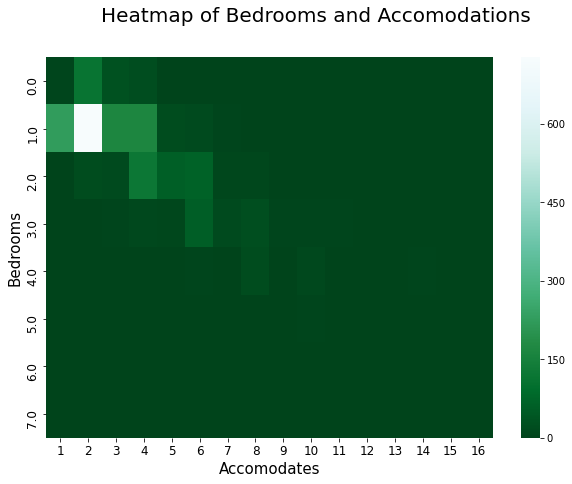

In [72]:
plt.figure(figsize=(10,7))
sns.heatmap(pd.crosstab(test.bedrooms,test.accommodates),cmap='BuGn_r')
plt.suptitle('Heatmap of Bedrooms and Accomodations',**title_font)
plt.xticks(fontsize=12,fontname='sans serif')
plt.xlabel('Accomodates',**label_font)
plt.yticks(fontsize=12,fontname='sans serif')
plt.ylabel('Bedrooms',**label_font)
plt.show()

In [73]:
train.loc[train.bedrooms.isna(),'accommodates'].values

array([2, 4, 3, 2, 2, 2, 1, 2, 4, 2, 2, 2, 2, 2], dtype=int64)

## Observations:
- Most concentration of accomodations is at 2 and the number of bedrooms for those are 1.0.
- Observations with missing values in bedrooms feature are having the mode value as 2. So imputing with 1.0 is the best.

In [74]:
train.bedrooms.fillna(1.0,inplace=True)

In [75]:
test.bedrooms.fillna(1.0,inplace=True)

### Beds

In [76]:
pd.crosstab(train.beds,train.accommodates)

accommodates    1     2    3     4    5    6   7    8   9   10  11  12  13  \
beds                                                                         
1.0           1269  3930  559   260   20   10   4    4   0   1   0   0   0   
2.0             24   327  442  1114  186  150  10    8   1   1   0   1   0   
3.0              7    13   45   188  183  364  30   48   2   2   1   1   1   
4.0              2     5    0    36   42  144  48  112   8  13   1   2   0   
5.0              0     1    1     1    7   26  17   55  13  23   3   8   1   
6.0              0     1    0     1    1   11   4   19   7  21   4  14   0   
7.0              0     0    0     0    0    1   2    1   3   8   1   3   2   
8.0              0     1    2     1    0    1   0    3   1   9   2   1   1   
9.0              0     0    0     0    0    0   0    0   1   1   0   1   3   
10.0             0     0    0     0    0    0   0    0   0   2   0   3   1   
11.0             0     0    0     0    0    0   0    0   0   0   1   0   0   
12.0             0     0    0     0    0    0   0    0   0   0   0   0   0   
14.0             0     0    0     0    0    0   0    0   0   0   0   0   0   
16.0             0     0    0     0    0    0   0    0   0   0   0   0   0   

accommodates  14  15  16  
beds                      
1.0            2   1   7  
2.0            0   0   3  
3.0            0   2   2  
4.0            0   0   2  
5.0            4   1   5  
6.0            2   1   4  
7.0            3   0   2  
8.0            2   0   2  
9.0            2   0   2  
10.0           2   2   1  
11.0           1   1   0  
12.0           0   0   3  
14.0           0   0   1  
16.0           0   0   3

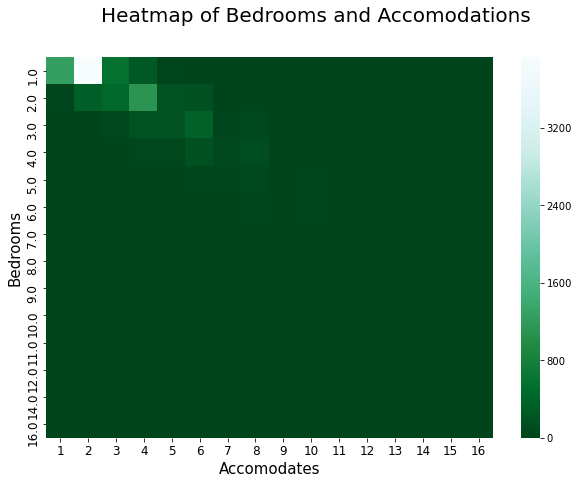

In [77]:
plt.figure(figsize=(10,7))
sns.heatmap(pd.crosstab(train.beds,train.accommodates),cmap='BuGn_r')
plt.suptitle('Heatmap of Bedrooms and Accomodations',**title_font)
plt.xticks(fontsize=12,fontname='sans serif')
plt.xlabel('Accomodates',**label_font)
plt.yticks(fontsize=12,fontname='sans serif')
plt.ylabel('Bedrooms',**label_font)
plt.show()

In [78]:
train.loc[train.beds.isna(),'accommodates'].values

array([2, 2, 2, 6, 5, 2, 2, 2, 2, 2, 1, 2, 1, 2, 1, 4, 1, 1, 1, 2, 2, 2,
       2], dtype=int64)

## Observations:
- Most concentration of accomodations is at 2 and the number of beds for those are 1.0.
- Observations with missing values in beds feature are having the mode value as 2. So imputing with 1.0 is the best.

In [79]:
train.beds.fillna(1.0,inplace=True)
test.beds.fillna(1.0,inplace=True)

In [80]:
missing_values_table(train)

Your selected dataframe has 29 columns.
There are 4 columns that have missing values.


Missing Values  % of Total Values   dtype
review_scores_rating             121                1.2  object
host_since                        21                0.2  object
first_review                       6                0.1  object
last_review                        2                0.0  object

In [81]:
missing_values_table(test)

Your selected dataframe has 28 columns.
There are 5 columns that have missing values.


Missing Values  % of Total Values   dtype
review_scores_rating             335               16.8  object
first_review                     317               15.8  object
last_review                      316               15.8  object
host_since                         4                0.2  object
name                               1                0.0  object

## Missing Values in review_scores_rating.

## Observation
- There are 121 missing values in train and 335 missing values in test for review_scores_rating feature.
- Imputing with mode which is 100 or any other value will cause noise in the model.
- Filling them with -1 and later binning the feature and marking them and 'Unknown' seems to be the best approach.

In [82]:
train.review_scores_rating.replace('No Review','0',inplace=True)
train.review_scores_rating.fillna('-1', inplace=True)

In [83]:
train.review_scores_rating = train.review_scores_rating.astype('int32')

In [84]:
bins = [-1,-0.1,1,50,76,95,100]

In [85]:
train['review_scores_rating_bins'] = pd.cut(train['review_scores_rating'], bins,include_lowest=True,labels=['Unknown','No Review','1%-50%','50%-75%','75%-95%','95%-100%'])

In [86]:
train['review_scores_rating_bins'].value_counts()

95%-100%     4222
75%-95%      3279
No Review    2165
50%-75%       181
Unknown       121
1%-50%         32
Name: review_scores_rating_bins, dtype: int64

In [87]:
test.review_scores_rating.replace('No Review','0',inplace=True)
test.review_scores_rating.fillna('-1', inplace=True)

In [88]:
test.review_scores_rating = test.review_scores_rating.astype('int32')

In [89]:
test['review_scores_rating_bins'] = pd.cut(test['review_scores_rating'], bins,include_lowest=True,labels=['Unknown','No Review','1%-50%','50%-75%','75%-95%','95%-100%'])

In [90]:
test['review_scores_rating_bins'].value_counts()

95%-100%     855
75%-95%      679
Unknown      335
No Review     91
50%-75%       33
1%-50%         7
Name: review_scores_rating_bins, dtype: int64

In [91]:
train.drop('review_scores_rating',axis=1,inplace = True)
test.drop('review_scores_rating',axis=1,inplace = True)

In [92]:
train.cleaning_fee.value_counts()

True     7312
False    2688
Name: cleaning_fee, dtype: int64

In [93]:
#pp.ProfileReport(train)

# Base Model

In [94]:
train.shape

(10000, 29)

In [95]:
train_target = train.log_price

In [96]:
train_features = train.drop('log_price',axis=1)

In [97]:
train_features['type'] = 'train'

In [98]:
test['type'] = 'test'

In [99]:
train_test_features = pd.concat([train_features,test])

In [100]:
train_test_features.shape

(12000, 29)

In [101]:
train_test_features.columns

Index(['id', 'property_type', 'room_type', 'amenities', 'accommodates',
       'bathrooms', 'bed_type', 'cancellation_policy', 'cleaning_fee', 'city',
       'description', 'first_review', 'host_has_profile_pic',
       'host_identity_verified', 'host_response_rate', 'host_since',
       'instant_bookable', 'last_review', 'latitude', 'longitude', 'name',
       'neighbourhood', 'number_of_reviews', 'zipcode', 'bedrooms', 'beds',
       'host_response_rate_bins', 'review_scores_rating_bins', 'type'],
      dtype='object')

In [102]:
base_cols = ['property_type', 'room_type',
       'accommodates', 'bathrooms', 'bed_type', 'cancellation_policy',
       'cleaning_fee', 'city',
       'host_has_profile_pic', 'host_identity_verified', 'host_response_rate_bins','instant_bookable','latitude',
       'longitude','number_of_reviews',
       'review_scores_rating_bins','bedrooms','type']

In [103]:
train_test_features_basic = train_test_features[base_cols].copy()

In [104]:
train_test_features_basic.dtypes

property_type                  object
room_type                      object
accommodates                    int64
bathrooms                     float64
bed_type                       object
cancellation_policy            object
cleaning_fee                     bool
city                           object
host_has_profile_pic             bool
host_identity_verified           bool
host_response_rate_bins      category
instant_bookable                 bool
latitude                      float64
longitude                     float64
number_of_reviews               int64
review_scores_rating_bins    category
bedrooms                      float64
type                           object
dtype: object

In [105]:
mmscaler = MinMaxScaler()

In [106]:
num_cols = ['accommodates','bathrooms','latitude','longitude','number_of_reviews','bedrooms']

In [107]:
train_test_features_basic[num_cols]= mmscaler.fit_transform(train_test_features_basic[num_cols])

In [108]:
cat_cols = ['property_type',
            'room_type',
            'bed_type',
            'cancellation_policy',
            'cleaning_fee',
            'city',
            'host_has_profile_pic',
            'host_identity_verified',
            'host_response_rate_bins',
            'review_scores_rating_bins',    
            'instant_bookable',]

In [109]:
train_test_features_basic = pd.get_dummies(train_test_features_basic, columns=cat_cols)

In [110]:
train_test_features_basic.drop(['instant_bookable_False','host_identity_verified_False','host_has_profile_pic_False','cleaning_fee_False'],axis=1,inplace = True)

In [111]:
train_test_features_basic.shape

(12000, 70)

In [112]:
train_basic = train_test_features_basic[train_test_features_basic.type == 'train'].drop('type',axis=1)

In [113]:
train_basic.shape

(10000, 69)

In [115]:
X = train_basic
y = train_target

In [116]:
X_train, X_valid, y_train, y_valid = train_test_split(X,y,train_size = 0.75)

In [117]:
X_test = train_test_features_basic[train_test_features_basic.type == 'test'].drop('type',axis=1)

In [118]:
print(X_train.shape)
print(X_valid.shape)
print(y_train.shape)
print(y_valid.shape)
print(X_test.shape)

(7500, 69)
(2500, 69)
(7500,)
(2500,)
(2000, 69)


## Xgboost Base Model

In [119]:
xgb_base_model = XGBRegressor()

In [120]:
xgb_base_model.fit(X_train,y_train)

[04:42:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [121]:
y_train_preds = xgb_base_model.predict(X_train)
y_valid_preds = xgb_base_model.predict(X_valid)

In [122]:
print('Train metrics :')
print('MSE :',mean_squared_error(y_train,y_train_preds))
print('RMSE :',rms(y_train,y_train_preds))

print('Validation metrics :')
print('MSE :',mean_squared_error(y_valid,y_valid_preds))
print('RMSE :',rms(y_valid,y_valid_preds))

Train metrics :
MSE : 0.15471509659602325
RMSE : 0.3933383995950859
Validation metrics :
MSE : 0.1821152849770946
RMSE : 0.42674967484122883


In [123]:
xgb_base_model = XGBRegressor(n_estimators=1500)

In [124]:
xgb_base_model.fit(X_train,y_train)

[04:42:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1500,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [125]:
y_train_preds = xgb_base_model.predict(X_train)
y_valid_preds = xgb_base_model.predict(X_valid)

print('Train metrics :')
print('MSE :',mean_squared_error(y_train,y_train_preds))
print('RMSE :',rms(y_train,y_train_preds))

print('Validation metrics :')
print('MSE :',mean_squared_error(y_valid,y_valid_preds))
print('RMSE :',rms(y_valid,y_valid_preds))

Train metrics :
MSE : 0.08173566683255792
RMSE : 0.2858945029771611
Validation metrics :
MSE : 0.17713735976844083
RMSE : 0.42087689384004007


In [126]:
eval_set = [(X_train, y_train), (X_valid, y_valid)]

In [127]:
xgb_base_model = XGBRegressor(n_estimators=1500)

In [128]:
xgb_base_model.fit(X_train, y_train, eval_metric=["rmse"], eval_set=eval_set, verbose=False)

[04:43:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1500,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

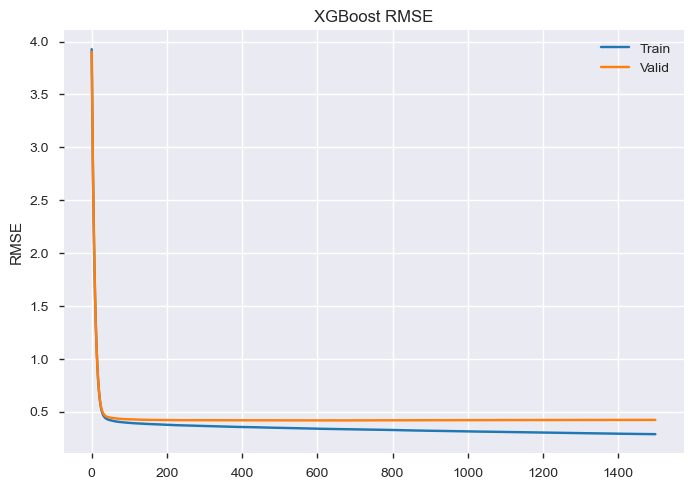

In [129]:
# retrieve performance metrics
results = xgb_base_model.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Valid')
ax.legend()
plt.ylabel('RMSE')
plt.title('XGBoost RMSE')
plt.show()

In [130]:
y_train_preds = xgb_base_model.predict(X_train)
y_valid_preds = xgb_base_model.predict(X_valid)

print('Train metrics :')
print('MSE :',mean_squared_error(y_train,y_train_preds))
print('RMSE :',rms(y_train,y_train_preds))

print('Validation metrics :')
print('MSE :',mean_squared_error(y_valid,y_valid_preds))
print('RMSE :',rms(y_valid,y_valid_preds))

Train metrics :
MSE : 0.08173566683255792
RMSE : 0.2858945029771611
Validation metrics :
MSE : 0.17713735976844083
RMSE : 0.42087689384004007


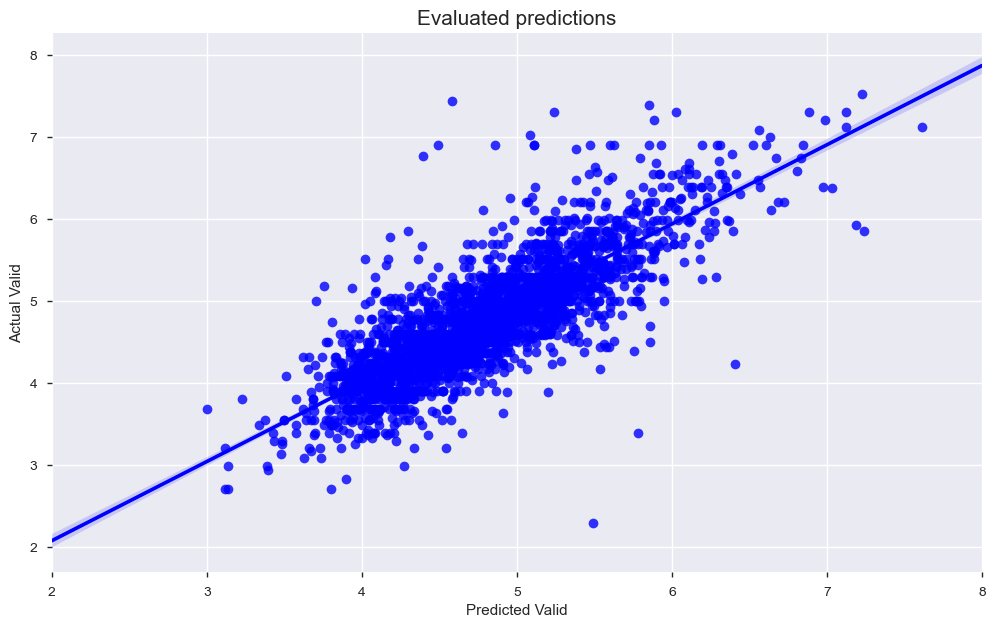

In [131]:
plt.figure(figsize=(12,7))
plt.xlim(2,8)
sns.regplot(y=y_valid, x=y_valid_preds, color='blue')
plt.title('Evaluated predictions', fontsize=15)
plt.xlabel('Predicted Valid')
plt.ylabel('Actual Valid')
plt.show()

In [132]:
feat_imp = pd.Series(xgb_base_model.feature_importances_,index=X.columns)
feat_importances_ordered = feat_imp.nlargest(n=len(feat_imp))

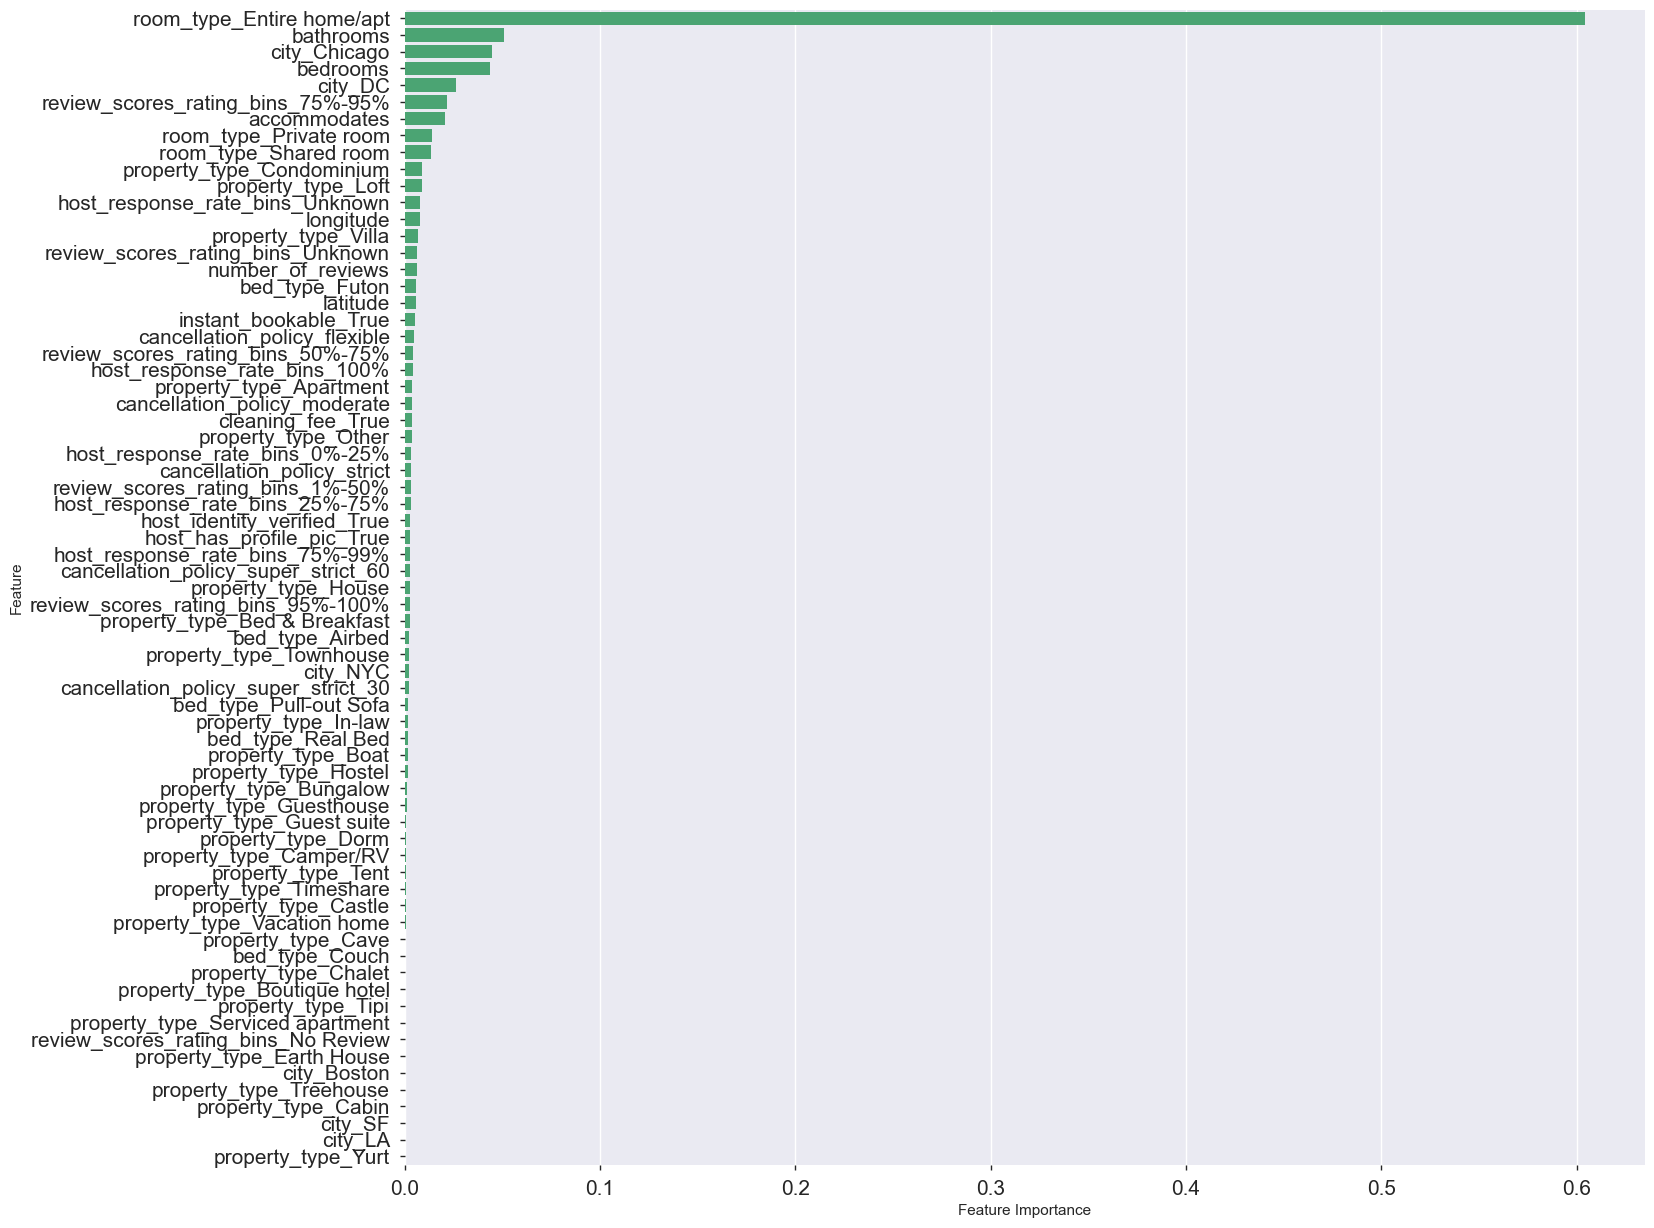

In [133]:
plt.figure(figsize=(16,15))
sns.barplot(x= feat_importances_ordered.values, y =feat_importances_ordered.index ,color='mediumseagreen')
plt.xticks(fontsize=15,rotation=0,fontname='sans serif')
plt.xlabel('Feature Importance')
plt.yticks(fontsize=15,fontname='sans serif')
plt.ylabel('Feature')
plt.show()

In [134]:
#y_test_preds = xgb_base_model.predict(X_test)
#temp = pd.DataFrame({'id':test.id,'log_price':y_test_preds})
#sample_submission.drop('log_price',axis=1,inplace=True)
#sample_submission = sample_submission.merge(temp)
#sample_submission.to_csv('xgboost_base_submission.csv',index=False)

### NOTE : This grid search took me so long to run so commenting

In [135]:
#xgb_model = XGBRegressor()
#parameters = {'learning_rate': [.03, 0.05, .07],'max_depth': [5, 10, 15, 20],'n_estimators': [100,250,500,750]}

In [136]:
#xgb_grid_model = GridSearchCV(xgb_model,parameters,cv = 5,verbose=True)

In [137]:
#xgb_grid_model.fit(X_train, y_train, eval_metric=["rmse"], eval_set=eval_set, verbose=False)

In [138]:
# retrieve performance metrics
#results = xgb_grid_model.best_estimator_.evals_result()
#epochs = len(results['validation_0']['rmse'])
#x_axis = range(0, epochs)
# plot log loss
#fig, ax = plt.subplots()
#ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
#ax.plot(x_axis, results['validation_1']['rmse'], label='Valid')
#ax.legend()
#plt.ylabel('RMSE')
#plt.title('XGBoost RMSE')
#plt.show()

In [140]:
#y_train_preds = xgb_grid_model.best_estimator_.predict(X_train)
#y_valid_preds = xgb_grid_model.best_estimator_.predict(X_valid)

#print('Train metrics :')
#print('MSE :',mean_squared_error(y_train,y_train_preds))
#print('RMSE :',rms(y_train,y_train_preds))

#print('Validation metrics :')
#print('MSE :',mean_squared_error(y_valid,y_valid_preds))
#print('RMSE :',rms(y_valid,y_valid_preds))

In [141]:
#xgb_grid_model.best_params_

In [142]:
#sample_submission = pd.read_csv('AirBnB10K/sample_submission2k.csv')
#y_test_preds = xgb_grid_model.best_estimator_.predict(X_test)
#temp = pd.DataFrame({'id':test.id,'log_price':y_test_preds})
#sample_submission.drop('log_price',axis=1,inplace=True)
#sample_submission = sample_submission.merge(temp)
#sample_submission.to_csv('xgboost_base_submission.csv',index=False)

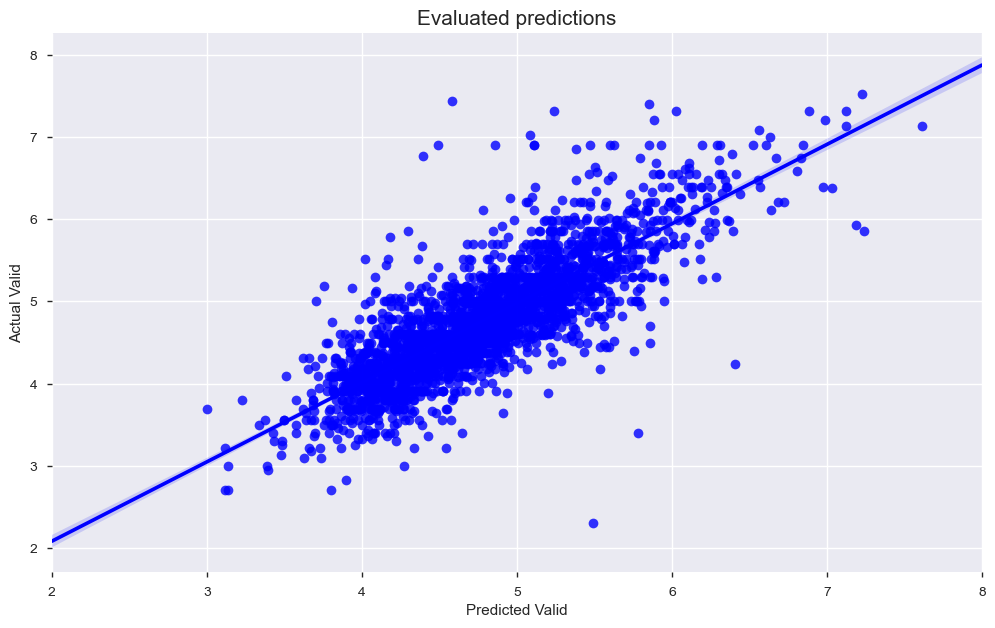

In [143]:
#plt.figure(figsize=(12,7))
#plt.xlim(2,8)
#sns.regplot(y=y_valid, x=y_valid_preds, color='blue')
#plt.title('Evaluated predictions', fontsize=15)
#plt.xlabel('Predicted Valid')
#plt.ylabel('Actual Valid')
#plt.show()

# Visualizations:

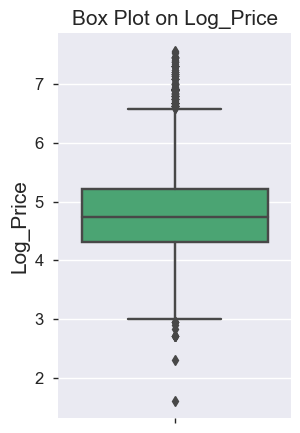

In [144]:
plt.figure(figsize=(3,5))
sns.boxplot(y='log_price',data=train,color='mediumseagreen',)
plt.yticks(fontsize=12,fontname='sans serif')
plt.ylabel('Log_Price',**label_font)
plt.title('Box Plot on Log_Price',**label_font)
plt.show()

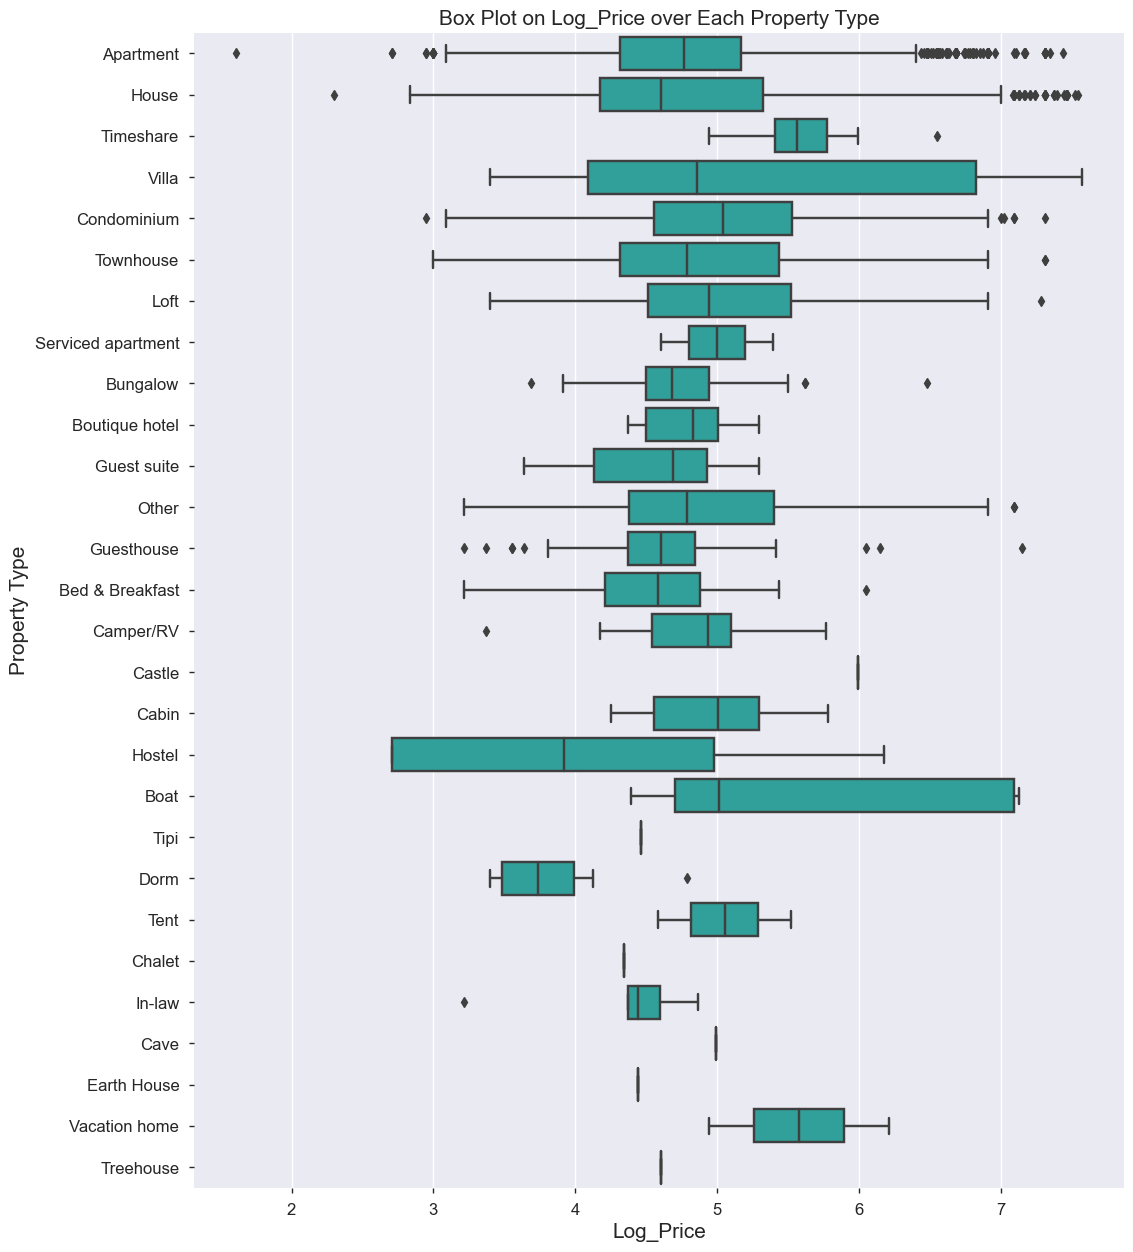

In [145]:
plt.figure(figsize=(12,15))
sns.boxplot(x='log_price',y='property_type',data=train,color='lightseagreen',)

plt.xticks(fontsize=12,fontname='sans serif')
plt.xlabel('Log_Price',**label_font)
plt.yticks(fontsize=12,fontname='sans serif')
plt.ylabel('Property Type',**label_font)
plt.title('Box Plot on Log_Price over Each Property Type',**label_font)
plt.show()

## Observations
- Some property types can be merged and further analysed if it makes an improvement.
- Some of the observations on properties that could be merged are
    - House + Appartment
    - Condominium + Town House + Loft + Villa
    - Service Appartment + Boutique + Cabin + Banglow + Guest Suite
    - Time Share + Castle + Vacation Home + Boat
    - Tree House + Earth House + Chalet + Tipi + Camper RV + Guest House + Others + Tent + Bread and Breakfast
    - Dorm + Hostel + Inlaw 

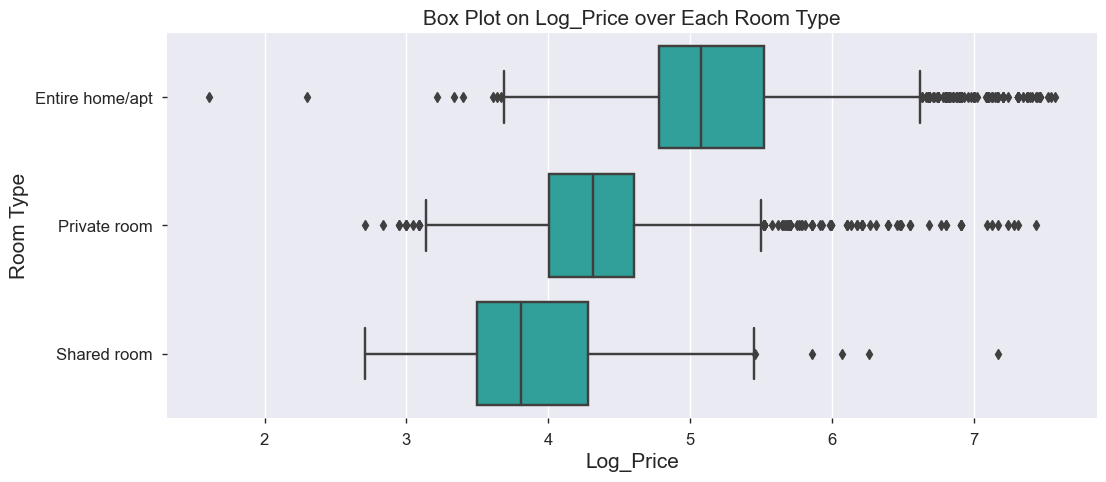

In [146]:
plt.figure(figsize=(12,5))
sns.boxplot(x='log_price',y='room_type',data=train,color='lightseagreen',)
plt.xticks(fontsize=12,fontname='sans serif')
plt.xlabel('Log_Price',**label_font)
plt.yticks(fontsize=12,fontname='sans serif')
plt.ylabel('Room Type',**label_font)
plt.title('Box Plot on Log_Price over Each Room Type',**label_font)
plt.show()

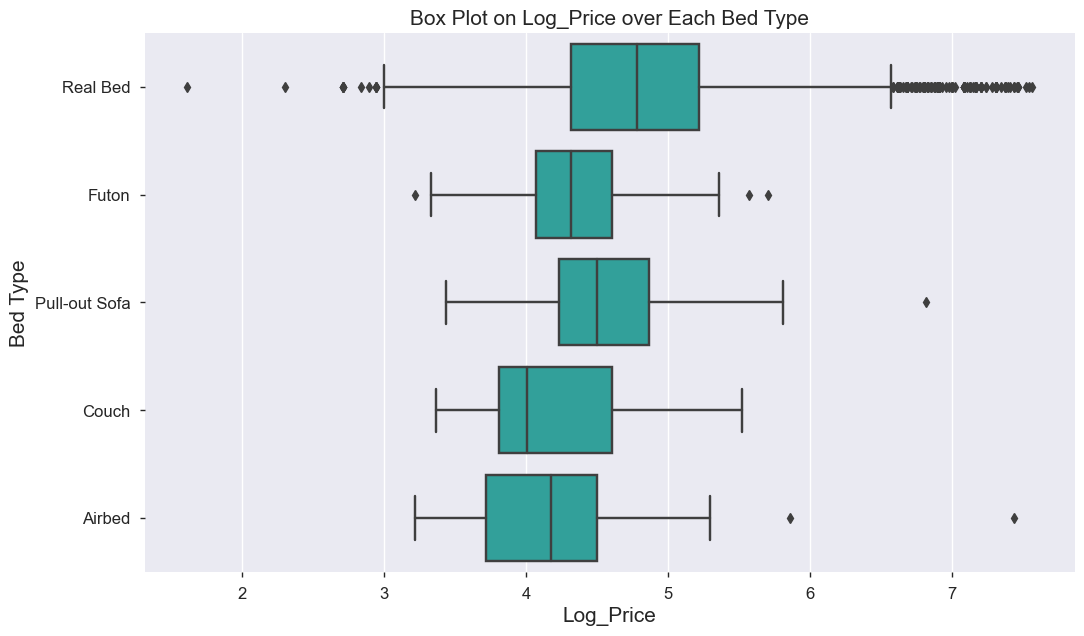

In [147]:
plt.figure(figsize=(12,7))
sns.boxplot(x='log_price',y='bed_type',data=train,color='lightseagreen',)
plt.xticks(fontsize=12,fontname='sans serif')
plt.xlabel('Log_Price',**label_font)
plt.yticks(fontsize=12,fontname='sans serif')
plt.ylabel('Bed Type',**label_font)
plt.title('Box Plot on Log_Price over Each Bed Type',**label_font)
plt.show()

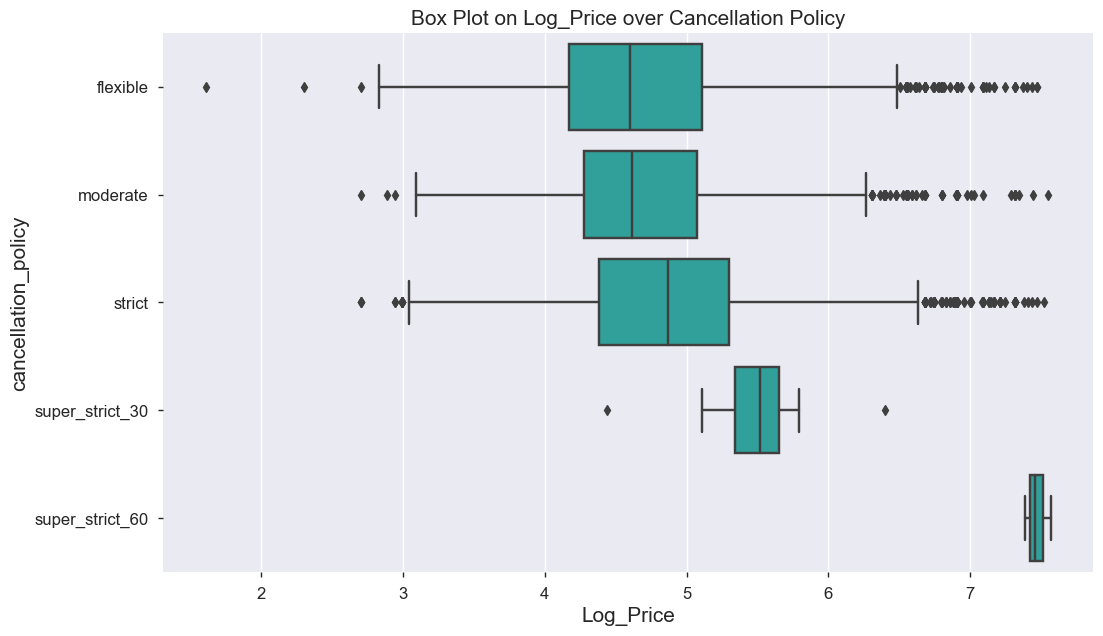

In [148]:
plt.figure(figsize=(12,7))
sns.boxplot(x='log_price',y='cancellation_policy',data=train,color='lightseagreen',)
plt.xticks(fontsize=12,fontname='sans serif')
plt.xlabel('Log_Price',**label_font)
plt.yticks(fontsize=12,fontname='sans serif')
plt.ylabel('cancellation_policy',**label_font)
plt.title('Box Plot on Log_Price over Cancellation Policy',**label_font)
plt.show()

## Observations:
- We can see a clear increase in the price for hotels that have strict cancellation policies.

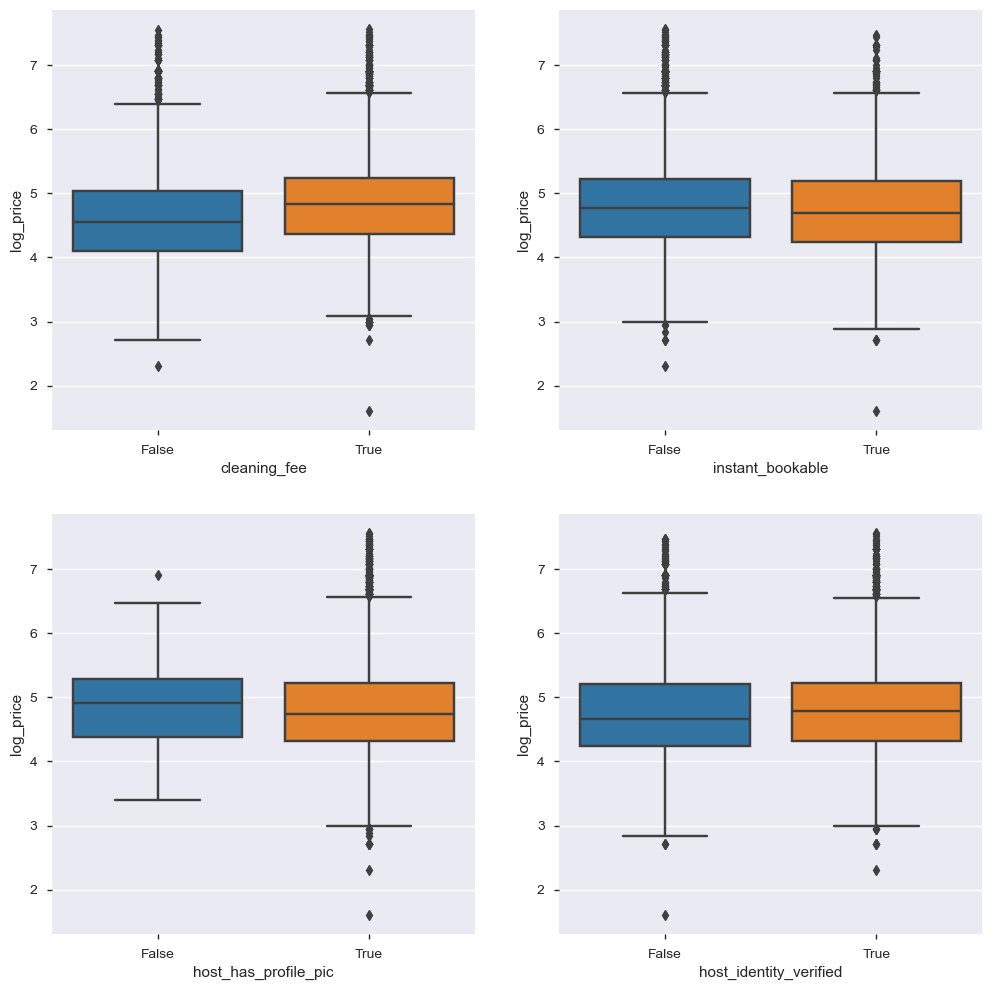

In [149]:
f, axes = plt.subplots(2, 2)
f.set_figheight(12)
f.set_figwidth(12)
sns.boxplot(y="log_price", x= "cleaning_fee", data=train,  orient='v' , ax=axes[0][0])
sns.boxplot(y="log_price", x= "instant_bookable", data=train,  orient='v' , ax=axes[0][1])
sns.boxplot(y="log_price", x= "host_has_profile_pic", data=train,  orient='v' , ax=axes[1][0])
sns.boxplot(y="log_price", x= "host_identity_verified", data=train,  orient='v' , ax=axes[1][1])
plt.show()

## Observations:
- cleaning_fee, instant_bookable, host_has_profile_pic, host_identity_verified are having similar distributions and similar central tendencies. They are not giving any specific information on log price.
- Removing them my give better model performance.

## Scatter Plots of log_prices over each cities latitude and longitude locations.

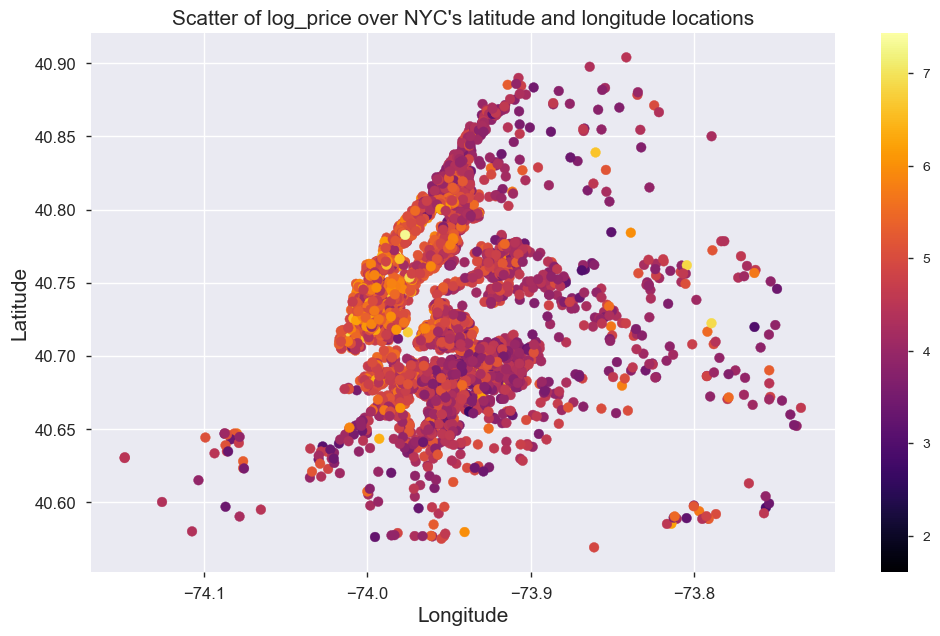

In [150]:
plt.figure(figsize=(12,7))
sc = plt.scatter(x = train.loc[train.city =='NYC','longitude'], 
            y = train.loc[train.city =='NYC','latitude'],
            c= train.loc[train.city =='NYC','log_price'],cmap='inferno')
plt.colorbar(sc)
plt.xticks(fontsize=12,fontname='sans serif')
plt.xlabel('Longitude',**label_font)
plt.yticks(fontsize=12,fontname='sans serif')
plt.ylabel('Latitude',**label_font)
plt.title("Scatter of log_price over NYC's latitude and longitude locations",**label_font)
plt.show()

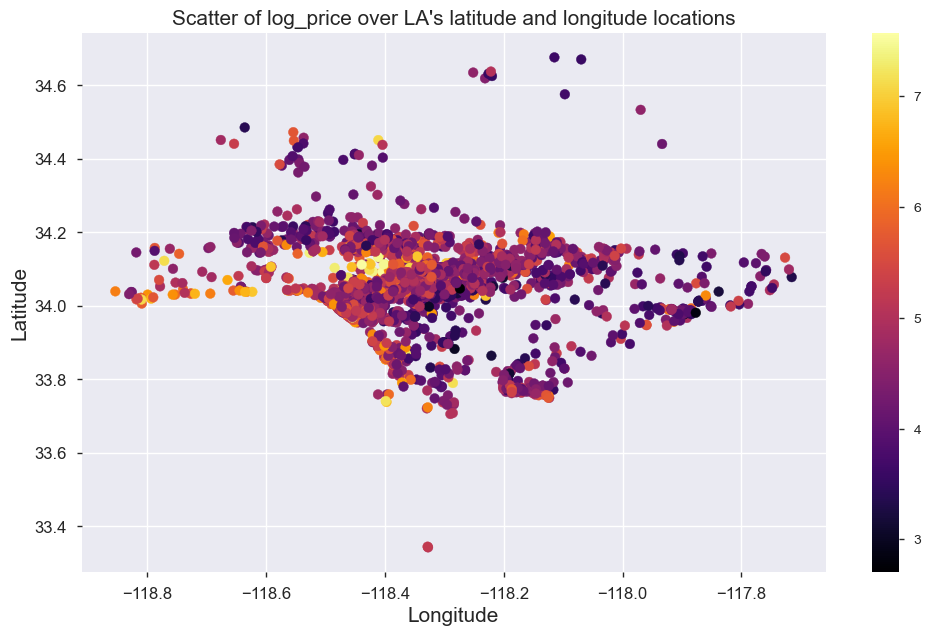

In [151]:
plt.figure(figsize=(12,7))
sc = plt.scatter(x = train.loc[train.city =='LA','longitude'], 
            y = train.loc[train.city =='LA','latitude'],
            c= train.loc[train.city =='LA','log_price'],cmap='inferno')
plt.colorbar(sc)
plt.xticks(fontsize=12,fontname='sans serif')
plt.xlabel('Longitude',**label_font)
plt.yticks(fontsize=12,fontname='sans serif')
plt.ylabel('Latitude',**label_font)
plt.title("Scatter of log_price over LA's latitude and longitude locations",**label_font)
plt.show()

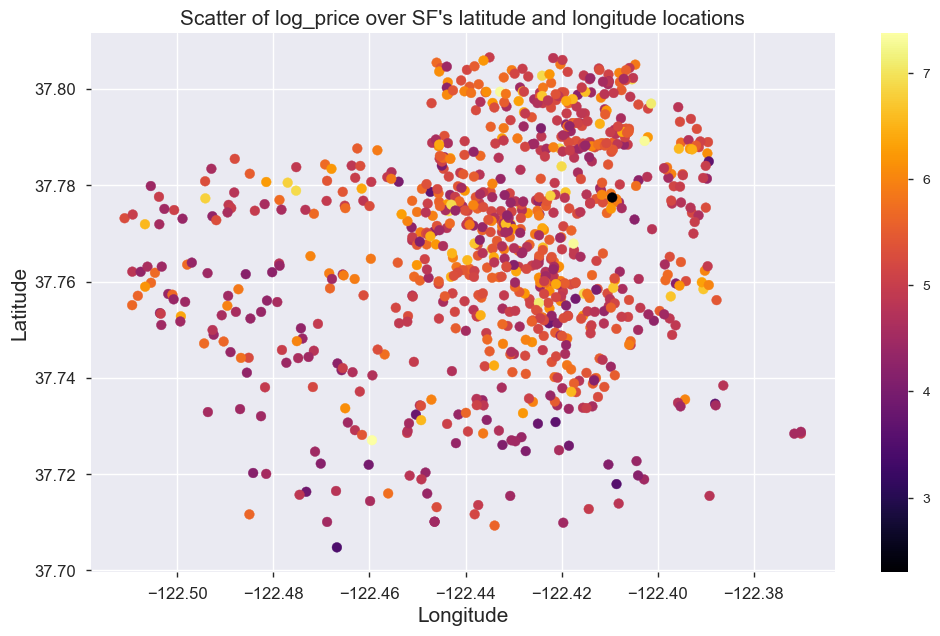

In [152]:
plt.figure(figsize=(12,7))
sc = plt.scatter(x = train.loc[train.city =='SF','longitude'], 
            y = train.loc[train.city =='SF','latitude'],
            c= train.loc[train.city =='SF','log_price'],cmap='inferno')
plt.colorbar(sc)
plt.xticks(fontsize=12,fontname='sans serif')
plt.xlabel('Longitude',**label_font)
plt.yticks(fontsize=12,fontname='sans serif')
plt.ylabel('Latitude',**label_font)
plt.title("Scatter of log_price over SF's latitude and longitude locations",**label_font)
plt.show()

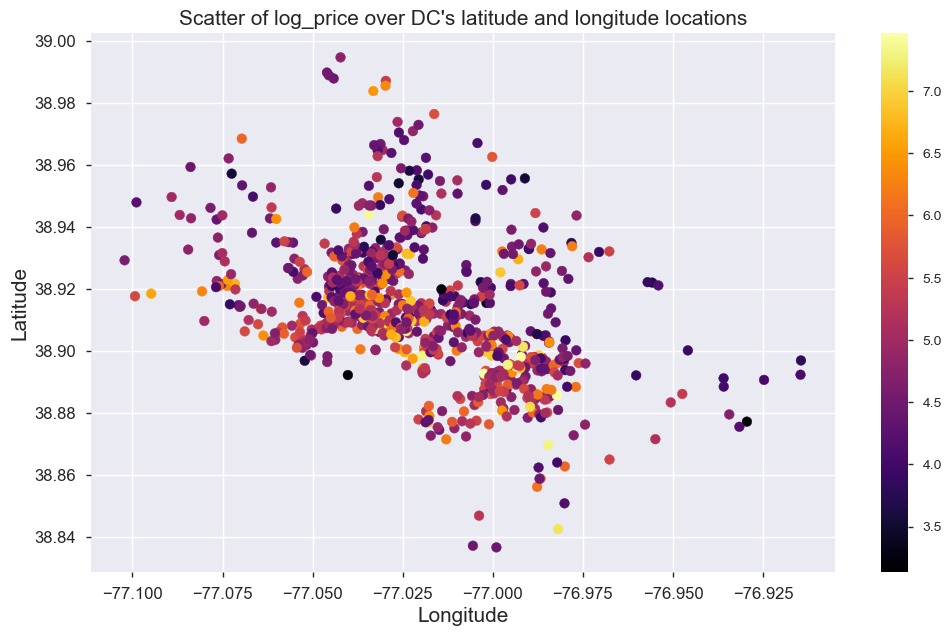

In [153]:
plt.figure(figsize=(12,7))
sc = plt.scatter(x = train.loc[train.city =='DC','longitude'], 
            y = train.loc[train.city =='DC','latitude'],
            c= train.loc[train.city =='DC','log_price'],cmap='inferno')
plt.colorbar(sc)
plt.xticks(fontsize=12,fontname='sans serif')
plt.xlabel('Longitude',**label_font)
plt.yticks(fontsize=12,fontname='sans serif')
plt.ylabel('Latitude',**label_font)
plt.title("Scatter of log_price over DC's latitude and longitude locations",**label_font)
plt.show()

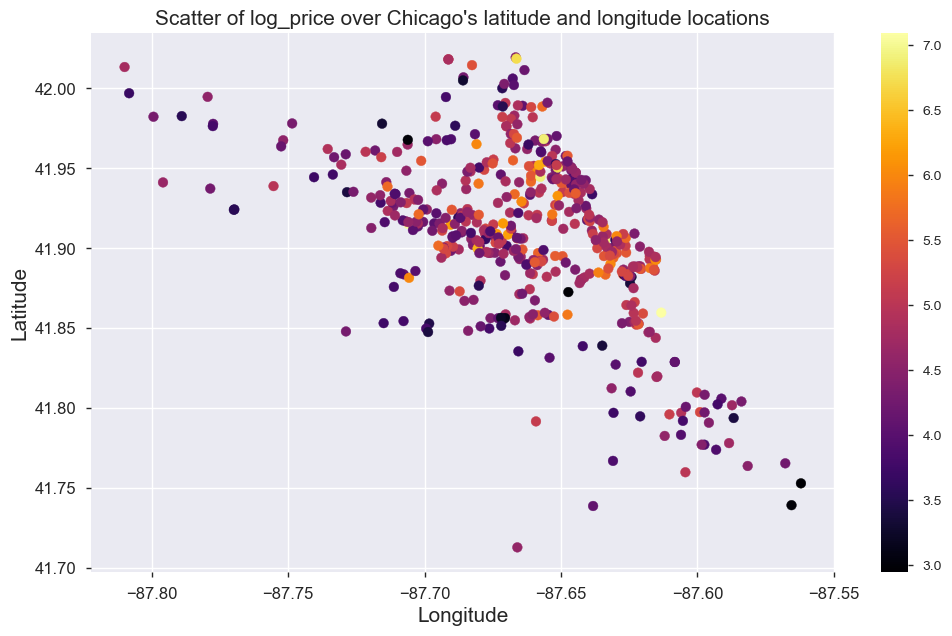

In [154]:
plt.figure(figsize=(12,7))
sc = plt.scatter(x = train.loc[train.city =='Chicago','longitude'], 
            y = train.loc[train.city =='Chicago','latitude'],
            c= train.loc[train.city =='Chicago','log_price'],cmap='inferno')
plt.colorbar(sc)
plt.xticks(fontsize=12,fontname='sans serif')
plt.xlabel('Longitude',**label_font)
plt.yticks(fontsize=12,fontname='sans serif')
plt.ylabel('Latitude',**label_font)
plt.title("Scatter of log_price over Chicago's latitude and longitude locations",**label_font)
plt.show()

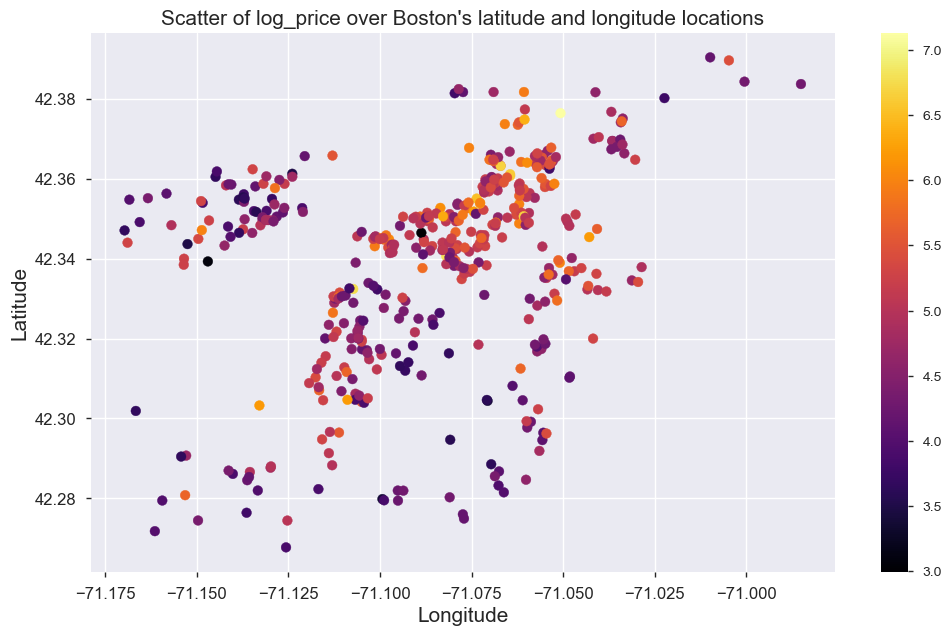

In [155]:
plt.figure(figsize=(12,7))
sc = plt.scatter(x = train.loc[train.city =='Boston','longitude'], 
            y = train.loc[train.city =='Boston','latitude'],
            c= train.loc[train.city =='Boston','log_price'],cmap='inferno')
plt.colorbar(sc)
plt.xticks(fontsize=12,fontname='sans serif')
plt.xlabel('Longitude',**label_font)
plt.yticks(fontsize=12,fontname='sans serif')
plt.ylabel('Latitude',**label_font)
plt.title("Scatter of log_price over Boston's latitude and longitude locations",**label_font)
plt.show()

## Observations:
- In all the cities we can see increase of log price in certain neighbourhoods.

## Neural Networks

- On base features

In [156]:
earlystopper = EarlyStopping(monitor='val_mse', patience=10, verbose=1)
reduce_lr = ReduceLROnPlateau(patience=5, verbose=1,monitor='val_mse',)

model = Sequential()

model.add(Dense(256, input_dim=69, activation='relu', kernel_initializer='normal',))
model.add(Dense(64, input_dim=256, activation='relu', kernel_initializer='normal',))
model.add(Dense(32, input_dim=64, activation='relu', kernel_initializer='normal'))
model.add(Dense(1, kernel_initializer='normal'))

# For a mean squared error regression problem
model.compile(loss='mae', optimizer='adam', metrics=['mse'])

r = model.fit(X_train, y_train, validation_data=[X_valid,y_valid], epochs=1000, batch_size=64, callbacks = [reduce_lr,earlystopper])

Instructions for updating:
Colocations handled automatically by placer.


C:\Users\lokesh\Anaconda3\lib\site-packages\tensorflow\python\framework\tensor_util.py:125: DeprecationWarning:

np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead

C:\Users\lokesh\Anaconda3\lib\site-packages\tensorflow\python\framework\tensor_util.py:125: DeprecationWarning:

np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead

C:\Users\lokesh\Anaconda3\lib\site-packages\tensorflow\python\framework\tensor_util.py:125: DeprecationWarning:

np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead

C:\Users\lokesh\Anaconda3\lib\site-packages\tensorflow\python\framework\tensor_util.py:125: DeprecationWarning:

np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead

C:\Users\lokesh\Anaconda3\lib\site-packages\tensorflow\python\framework\tensor_util.py:125: DeprecationWarning:

np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead

C:\Users\lokesh\Anaconda3\lib\site-packages\tensorflow\python\framework\tensor_util.p

Instructions for updating:
Use tf.cast instead.


C:\Users\lokesh\Anaconda3\lib\site-packages\tensorflow\python\framework\tensor_util.py:125: DeprecationWarning:

np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead

C:\Users\lokesh\Anaconda3\lib\site-packages\tensorflow\python\framework\tensor_util.py:131: DeprecationWarning:

np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead

C:\Users\lokesh\Anaconda3\lib\site-packages\tensorflow\python\framework\tensor_util.py:131: DeprecationWarning:

np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead

C:\Users\lokesh\Anaconda3\lib\site-packages\tensorflow\python\framework\tensor_util.py:131: DeprecationWarning:

np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead

C:\Users\lokesh\Anaconda3\lib\site-packages\tensorflow\python\framework\tensor_util.py:131: DeprecationWarning:

np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead

C:\Users\lokesh\Anaconda3\lib\site-packages\tensorflow\python\framework\tensor_util.p

C:\Users\lokesh\Anaconda3\lib\site-packages\tensorflow\python\framework\tensor_util.py:125: DeprecationWarning:

np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead

C:\Users\lokesh\Anaconda3\lib\site-packages\tensorflow\python\framework\tensor_util.py:125: DeprecationWarning:

np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead

C:\Users\lokesh\Anaconda3\lib\site-packages\tensorflow\python\framework\tensor_util.py:125: DeprecationWarning:

np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead

C:\Users\lokesh\Anaconda3\lib\site-packages\tensorflow\python\framework\tensor_util.py:125: DeprecationWarning:

np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead

C:\Users\lokesh\Anaconda3\lib\site-packages\tensorflow\python\framework\tensor_util.py:125: DeprecationWarning:

np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead

C:\Users\lokesh\Anaconda3\lib\site-packages\tensorflow\python\framework\tensor_util.p

Train on 7500 samples, validate on 2500 samples
Epoch 1/1000
7500/7500 [==============================] - 0s 49us/step - loss: 1.4525 - mse: 4.9851 - val_loss: 0.3863 - val_mse: 0.2620
Epoch 2/1000
7500/7500 [==============================] - 0s 32us/step - loss: 0.3634 - mse: 0.2348 - val_loss: 0.3664 - val_mse: 0.2402
Epoch 3/1000
7500/7500 [==============================] - 0s 33us/step - loss: 0.3563 - mse: 0.2238 - val_loss: 0.3663 - val_mse: 0.2434
Epoch 4/1000
7500/7500 [==============================] - 0s 31us/step - loss: 0.3544 - mse: 0.2220 - val_loss: 0.3731 - val_mse: 0.2514
Epoch 5/1000
7500/7500 [==============================] - 0s 30us/step - loss: 0.3566 - mse: 0.2251 - val_loss: 0.3783 - val_mse: 0.2416
Epoch 6/1000
7500/7500 [==============================] - 0s 32us/step - loss: 0.3514 - mse: 0.2174 - val_loss: 0.3721 - val_mse: 0.2349
Epoch 7/1000
7500/7500 [==============================] - 0s 31us/step - loss: 0.3492 - mse: 0.2156 - val_loss: 0.3929 - val_mse: 

In [157]:
y_train_preds = model.predict(X_train).ravel()
y_valid_preds = model.predict(X_valid).ravel()

print('Train metrics :')
print('MSE :',mean_squared_error(y_train,y_train_preds))
print('RMSE :',rms(y_train,y_train_preds))

print('Validation metrics :')
print('MSE :',mean_squared_error(y_valid,y_valid_preds))
print('RMSE :',rms(y_valid,y_valid_preds))

Train metrics :
MSE : 0.18299686760005104
RMSE : 0.4277813315235378
Validation metrics :
MSE : 0.22806001449912064
RMSE : 0.477556294586429


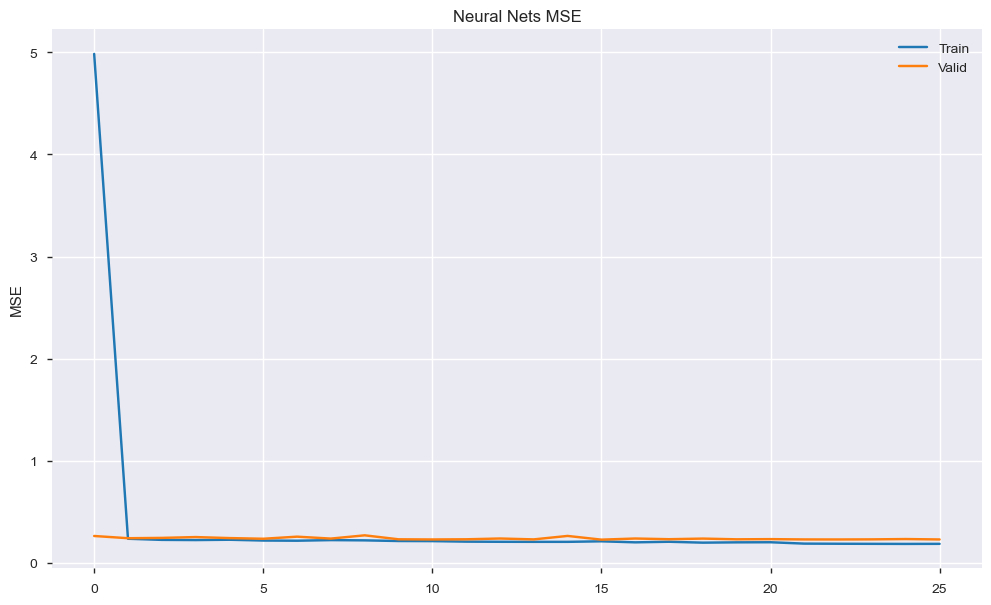

In [158]:
# plot some data
fig, ax = plt.subplots()
fig.set_figheight(7)
fig.set_figwidth(12)
ax.plot(r.history['mse'], label='Train')
ax.plot(r.history['val_mse'], label='Valid')
ax.legend()
plt.ylabel('MSE')
plt.title('Neural Nets MSE')
plt.show()

## Text Data: Amenities, Description, Names

## Amenities

In [159]:
train['cleaned_amenities'] = train.amenities.apply(lambda x: x.strip('{}').replace('"','').lower().split(','))

In [160]:
train['number_of_amenities'] = train.cleaned_amenities.apply(lambda x: len(x))

In [161]:
amenities_list = list(train['cleaned_amenities'])

In [162]:
all_amenities = [amenity for i in amenities_list for amenity in i]

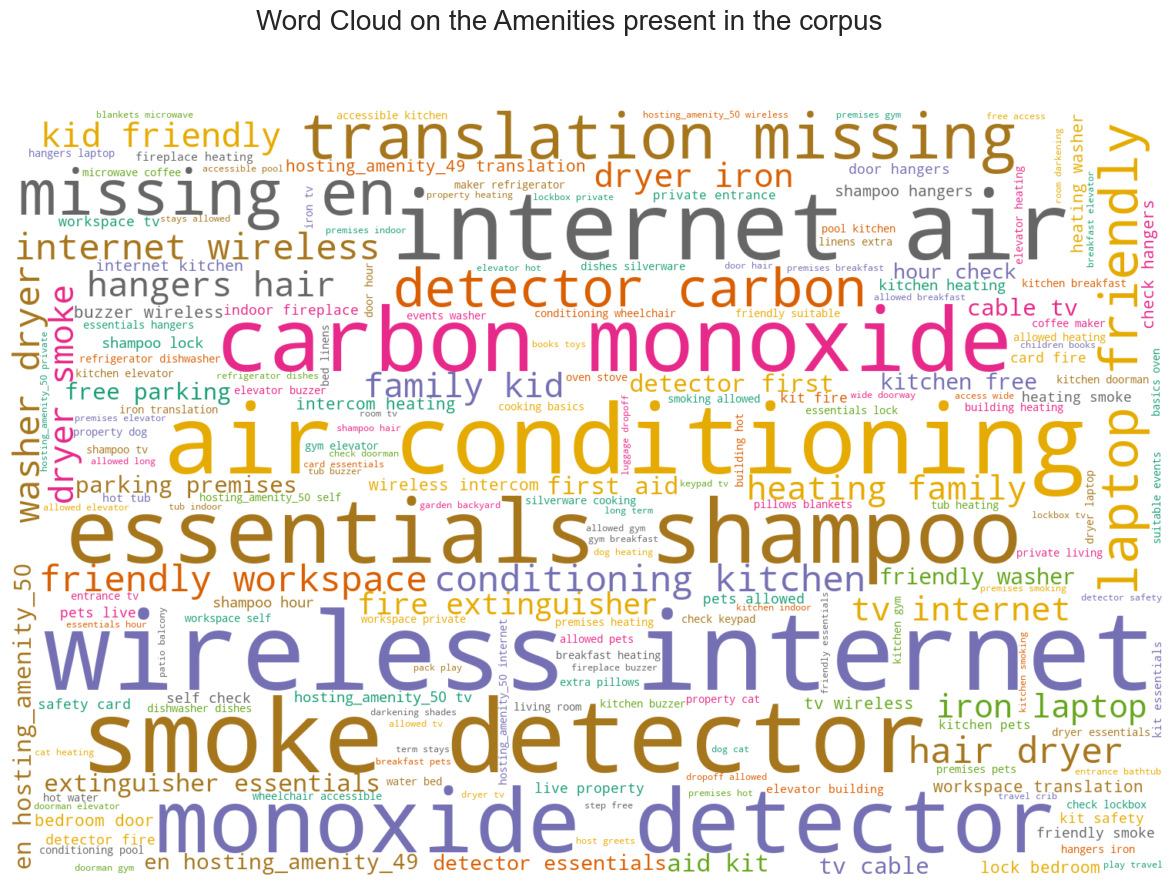

In [163]:
wordcloud = WordCloud(width=1500, height=1000, random_state=21,
                      background_color ='white',min_font_size = 10).generate(' '.join(all_amenities))

plt.figure(figsize=(15,10))
plt.imshow(wordcloud.recolor(colormap='Dark2'), interpolation="bilinear")
plt.axis('off')
plt.suptitle('Word Cloud on the Amenities present in the corpus',size = 20)
plt.show()

# Observations:
- Most basic essentials are listed by many properties.
- Fire safety features are aslo listed by many properties, which is a good sign.

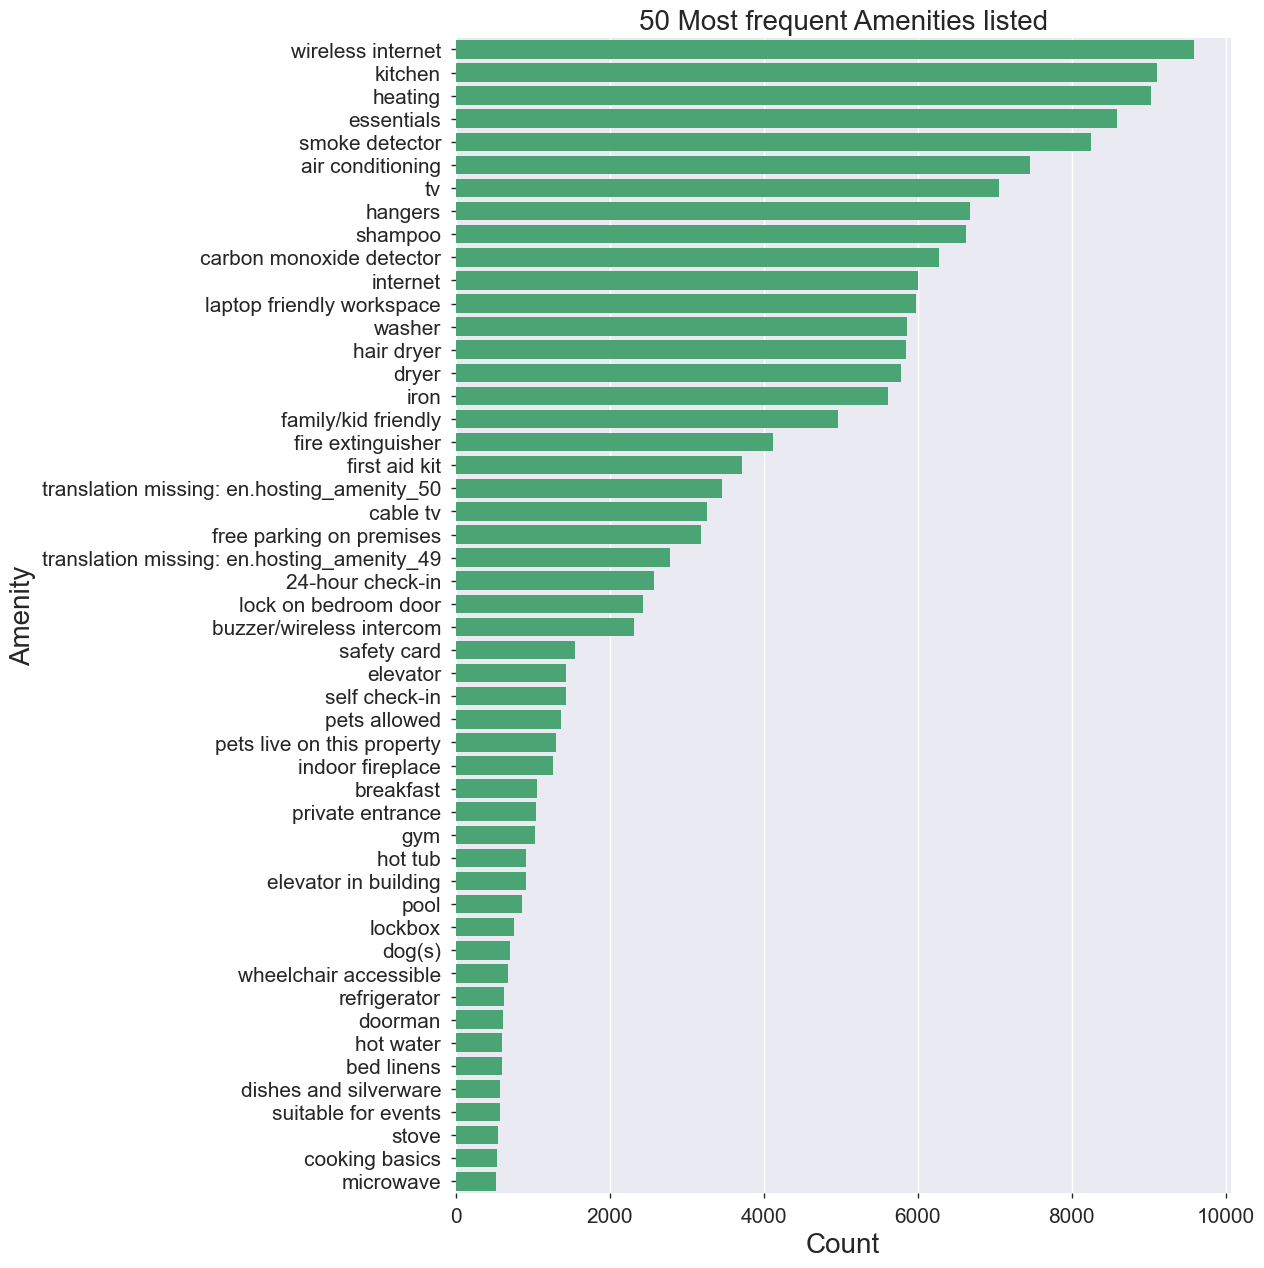

In [164]:
a = nltk.FreqDist(all_amenities)
d = pd.DataFrame({'Amenity': list(a.keys()),
                  'Count': list(a.values())})
   
d = d.nlargest(columns="Count", n = 50) 
plt.figure(figsize=(10,15))
sns.barplot(data=d, x= "Count", y ="Amenity" ,color='mediumseagreen')
plt.xticks(fontsize=15,rotation=0,fontname='sans serif')
plt.ylabel('Amenity',fontsize=20)
plt.yticks(fontsize=15,fontname='sans serif')
plt.xlabel('Count',fontsize=20)
plt.title('50 Most frequent Amenities listed',size = 20)
plt.show()

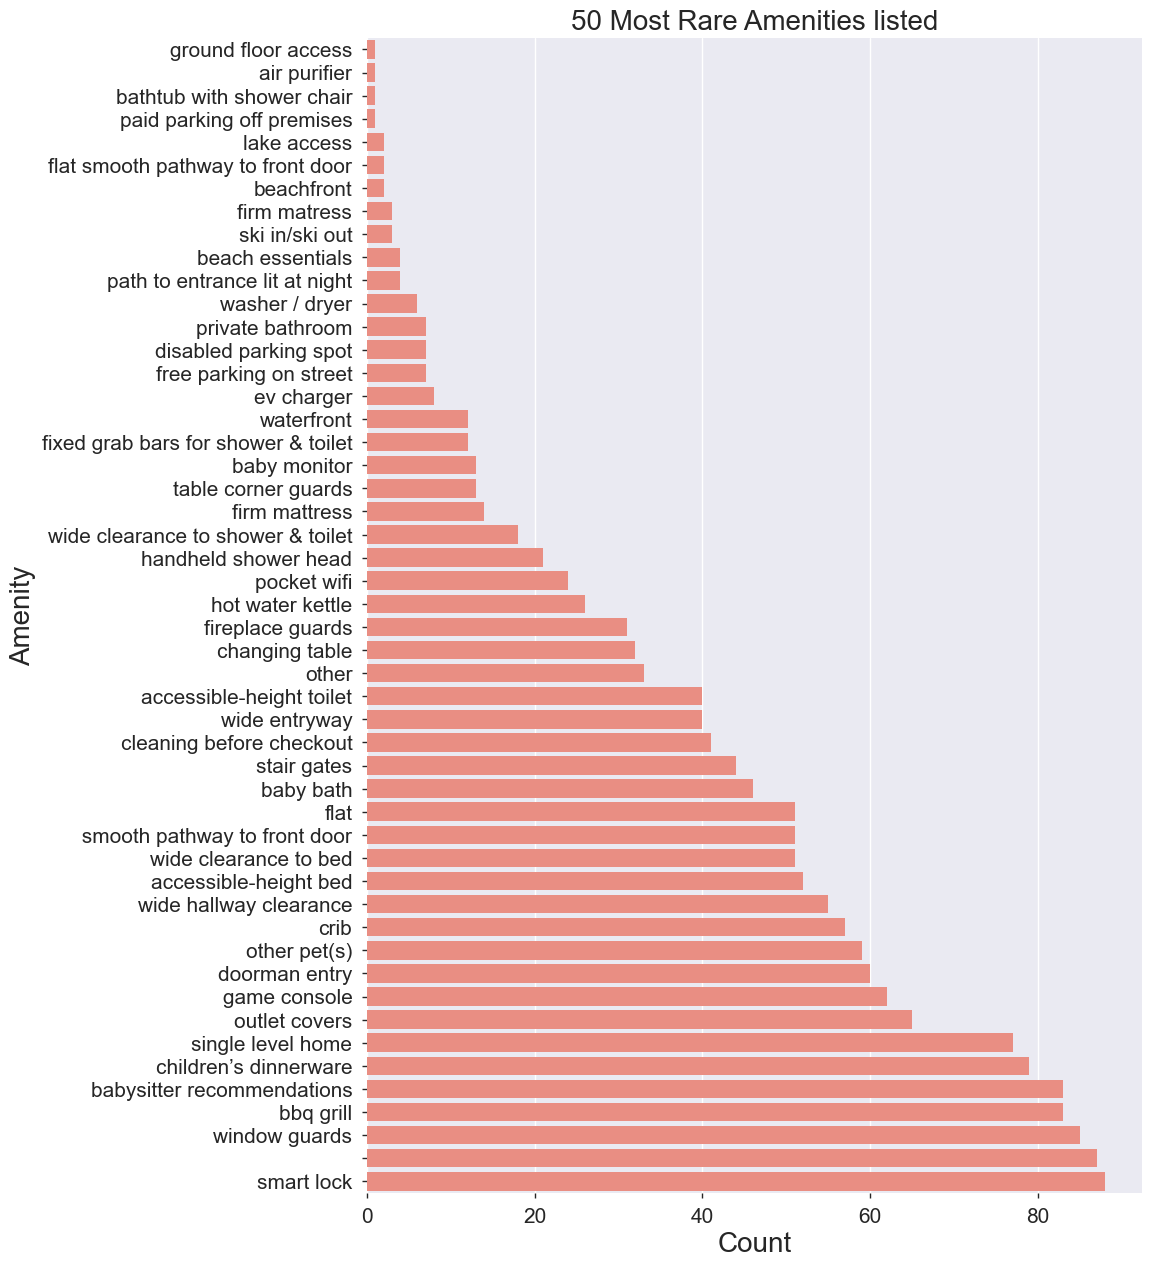

In [165]:
a = nltk.FreqDist(all_amenities)
d = pd.DataFrame({'Amenity': list(a.keys()),
                  'Count': list(a.values())})

d = d.nsmallest(columns="Count", n = 50)
bottom_50_frequent_amenities = d.Amenity
plt.figure(figsize=(10,15))
sns.barplot(data=d, x= "Count", y ="Amenity" ,color='salmon')
plt.xticks(fontsize=15,rotation=0,fontname='sans serif')
plt.ylabel('Amenity',fontsize=20)
plt.yticks(fontsize=15,fontname='sans serif')
plt.xlabel('Count',fontsize=20)
plt.title('50 Most Rare Amenities listed',size = 20)
plt.show()

## Descriptions

In [166]:
CONTRACTION_MAP = {"ain't": 'is not', "aren't": 'are not', "can't": 'cannot', "can't've": 'cannot have', "'cause": 'because', "could've": 'could have', "couldn't": 'could not', "couldn't've": 'could not have', "didn't": 'did not', "doesn't": 'does not', "don't": 'do not', "hadn't": 'had not', "hadn't've": 'had not have', "hasn't": 'has not', "haven't": 'have not', "he'd": 'he would', "he'd've": 'he would have', "he'll": 'he will', "he'll've": 'he he will have', "he's": 'he is', "how'd": 'how did', "how'd'y": 'how do you', "how'll": 'how will', "how's": 'how is', "I'd": 'I would', "I'd've": 'I would have', "I'll": 'I will', "I'll've": 'I will have', "I'm": 'I am', "I've": 'I have', "i'd": 'i would', "i'd've": 'i would have', "i'll": 'i will', "i'll've": 'i will have', "i'm": 'i am', "i've": 'i have', "isn't": 'is not', "it'd": 'it would', "it'd've": 'it would have', "it'll": 'it will', "it'll've": 'it will have', "it's": 'it is', "let's": 'let us', "ma'am": 'madam', "mayn't": 'may not', "might've": 'might have', "mightn't": 'might not', "mightn't've": 'might not have', "must've": 'must have', "mustn't": 'must not', "mustn't've": 'must not have', "needn't": 'need not', "needn't've": 'need not have', "o'clock": 'of the clock', "oughtn't": 'ought not', "oughtn't've": 'ought not have', "shan't": 'shall not', "sha'n't": 'shall not', "shan't've": 'shall not have', "she'd": 'she would', "she'd've": 'she would have', "she'll": 'she will', "she'll've": 'she will have', "she's": 'she is', "should've": 'should have', "shouldn't": 'should not', "shouldn't've": 'should not have', "so've": 'so have', "so's": 'so as', "that'd": 'that would', "that'd've": 'that would have', "that's": 'that is', "there'd": 'there would', "there'd've": 'there would have', "there's": 'there is', "they'd": 'they would', "they'd've": 'they would have', "they'll": 'they will', "they'll've": 'they will have', "they're": 'they are', "they've": 'they have', "to've": 'to have', "wasn't": 'was not', "we'd": 'we would', "we'd've": 'we would have', "we'll": 'we will', "we'll've": 'we will have', "we're": 'we are', "we've": 'we have', "weren't": 'were not', "what'll": 'what will', "what'll've": 'what will have', "what're": 'what are', "what's": 'what is', "what've": 'what have', "when's": 'when is', "when've": 'when have', "where'd": 'where did', "where's": 'where is', "where've": 'where have', "who'll": 'who will', "who'll've": 'who will have', "who's": 'who is', "who've": 'who have', "why's": 'why is', "why've": 'why have', "will've": 'will have', "won't": 'will not', "won't've": 'will not have', "would've": 'would have', "wouldn't": 'would not', "wouldn't've": 'would not have', "y'all": 'you all', "y'all'd": 'you all would', "y'all'd've": 'you all would have', "y'all're": 'you all are', "y'all've": 'you all have', "you'd": 'you would', "you'd've": 'you would have', "you'll": 'you will', "you'll've": 'you will have', "you're": 'you are', "you've": 'you have'}

In [167]:
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())),
                                      flags=re.IGNORECASE | re.DOTALL)

    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
            if contraction_mapping.get(match)\
            else contraction_mapping.get(match.lower())
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction

    expanded_text = re.sub("’", "'", text)
    expanded_text = contractions_pattern.sub(expand_match, expanded_text)

    return expanded_text

In [168]:
def clean_doc(doc):
    # Removing contractions
    doc = expand_contractions(doc)
    
    # split into tokens by white space
    tokens = doc.split(' ')
    
    # Converting into lower case
    tokens = [w.lower() for w in tokens]
    
    # remove special characters from each token
    tokens = [re.sub(r"[^a-zA-Z#\s]",'',i) for i in tokens]
    tokens = [re.sub(r"[\r\n]",'',i) for i in tokens]
    
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    
    # lemmatizing
    lmtzr = nltk.stem.WordNetLemmatizer()
    tokens = [lmtzr.lemmatize(w) for w in tokens]
    
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    return tokens

In [169]:
train['modified_description'] = train['description'].apply(lambda x: clean_doc(x))

In [170]:
train['modified_description'][:5]

0    [large, apartment, lot, natural, light, next, ...
1    [true, onebedroom, apartment, beautiful, west,...
2    [place, close, prospect, park, phat, albert, i...
3    [upper, west, side, private, bedroom, fully, f...
4    [bed, bath, downtown, sf, near, union, square,...
Name: modified_description, dtype: object

In [171]:
all_words = [word for i in list(train['modified_description']) for word in i]

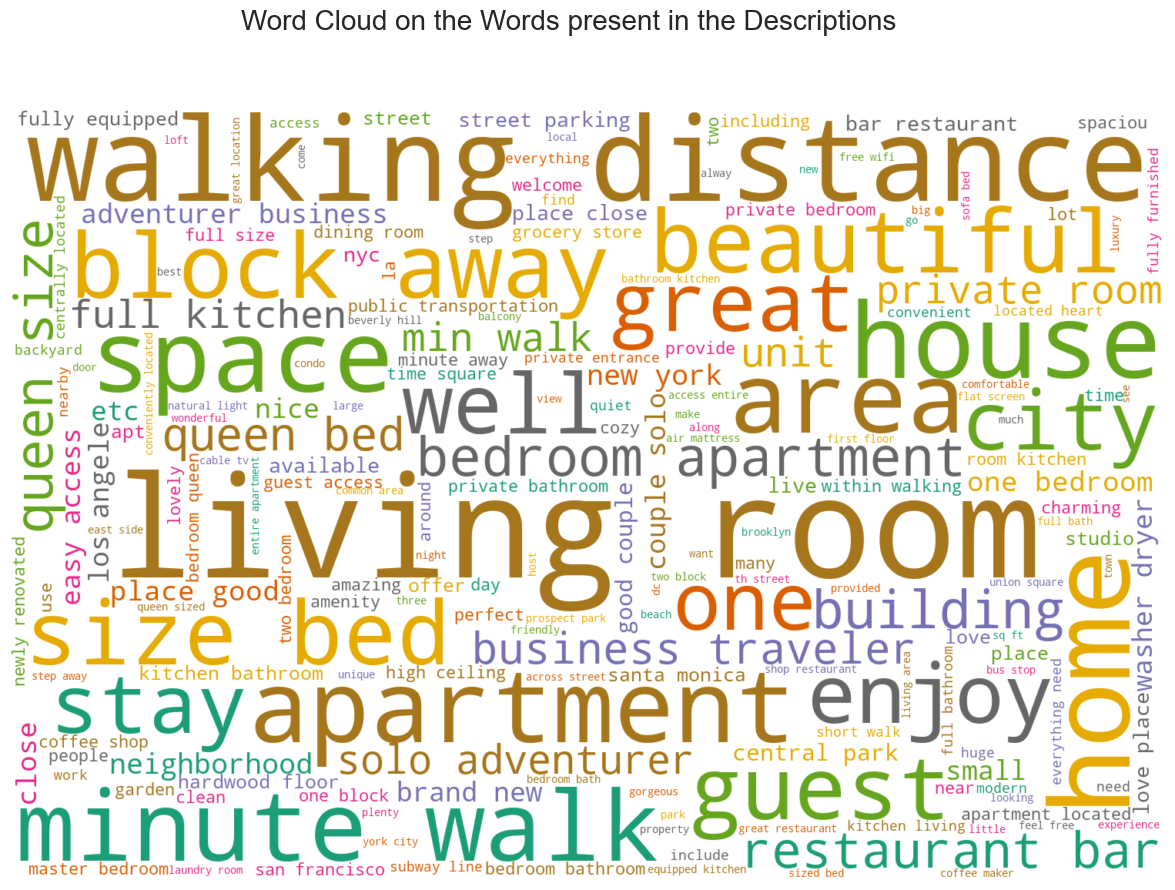

In [172]:
wordcloud = WordCloud(width=1500, height=1000, random_state=21,
                      background_color ='white',min_font_size = 10).generate(' '.join(all_words))

plt.figure(figsize=(15,10))
plt.imshow(wordcloud.recolor(colormap='Dark2'), interpolation="bilinear")
plt.axis('off')
plt.suptitle('Word Cloud on the Words present in the Descriptions',size = 20)
plt.show()

## Topic Modeling using LDA on Descriptions

In [173]:
gensim_dictionary = Dictionary(train['modified_description'])
gensim_dictionary.filter_extremes(no_below=10, no_above=0.4)
gensim_dictionary.compactify()

In [174]:
def gensim_bow_generator(text):
    for description in train['modified_description']:
        yield gensim_dictionary.doc2bow(description)

In [175]:
MmCorpus.serialize('gensim_bow_corpus_all.mm',
                   gensim_bow_generator(train['modified_description']))

In [176]:
gensim_bow_corpus = MmCorpus('gensim_bow_corpus_all.mm')

In [177]:
lda = LdaMulticore(gensim_bow_corpus,num_topics=4,id2word=gensim_dictionary)

In [178]:
coherencemodel = CoherenceModel(model=lda, texts=train['modified_description'], dictionary=gensim_dictionary, coherence='c_v')

In [179]:
perplexity = []
coherence = []

In [180]:
#for k in range(3,15):
#    lda = LdaMulticore(gensim_bow_corpus,
#                   num_topics=k,
#                   id2word=gensim_dictionary)
#    perplexity.append(lda.log_perplexity(gensim_bow_corpus))
#    coherencemodel = CoherenceModel(model=lda, texts=train['modified_description'], dictionary=gensim_dictionary, coherence='c_v')
#    coherence.append(coherencemodel.get_coherence())

In [181]:
#plt.figure(figsize=(10,7))
#x = range(3,15)
#plt.plot(x, coherence)
#plt.xlabel("Num Topics",**label_font)
#plt.xticks(fontsize=12,fontname='sans serif')
#plt.ylabel("Coherence score",**label_font)
#plt.yticks(fontsize=12,fontname='sans serif')
#plt.legend(("coherence_values"), loc='best',)
#plt.title('Coherence vs Number of Topics',**label_font)
#plt.show()

## Observation
- Coherence is maximum for 4 topics.
- This might change if we run the model again

In [183]:
LDAvis_prepared = pyLDAvis.gensim.prepare(lda, gensim_bow_corpus,
                                          gensim_dictionary)

In [184]:
pyLDAvis.display(LDAvis_prepared)

#### Interpreting the above plot

- On the left, We can see Intertopic Distance Map which shows all the topics in 2d using multidimensional scaling (MDS). There are no overlapping between the topics.
- Each Topic can be analysed by clicking on it.
- When no topic is selected in the plot on the left, the bar chart shows the top-30 most "salient" terms in the corpus. 
- A term's saliency is a measure of both how frequent the term is in the corpus and how "distinctive" it is in distinguishing between different topics.
- When a particular topic is selected, the bar chart changes to show the top-30 most "relevant" terms for the selected topic. 

- The relevance metric is controlled by the parameter  λ , which can be adjusted with a slider above the bar chart.
- Setting the  λ  parameter close to 1.0 (the default) will rank the terms solely according to their probability within the topic.
- Setting  λ  close to 0.0 will rank the terms solely according to their "distinctiveness" or "exclusivity" within the topic — i.e., terms that occur only in this topic, and do not occur in other topics.
- Adjusting the λ helps us to interpret the topics more clearly.

- As per our analysis.
- Topic 1: Friendly neighbourhood with parks to walk around.
- Topic 2: Neighborhood with easily accessible transit places like Trains.
- Topic 3: Private are with some accessibity to close by places.
- Topic 4: Private and luxury.
- NOTE: Results may vary if re-run LDA

### Assigning topics to our descriptions

In [185]:
train['modified_description_bow'] = train.modified_description.apply(lambda x : gensim_dictionary.doc2bow(x))

In [186]:
train['topics_probs'] = train['modified_description_bow'].apply(lambda x: lda.get_document_topics(x,minimum_probability=0))

In [187]:
train['description_topic_1'] = train['topics_probs'].apply(lambda x: x[0][1] if x[0][0] == 0 else 0)

train['description_topic_2'] = train['topics_probs'].apply(lambda x: x[1][1] if x[1][0] == 1 else 0)

train['description_topic_3'] = train['topics_probs'].apply(lambda x: x[2][1] if x[2][0] == 2 else 0)

train['description_topic_4'] = train['topics_probs'].apply(lambda x: x[3][1] if x[3][0] == 3 else 0)

In [188]:
train['max_probable_topic'] = train.loc[:,('description_topic_1','description_topic_2','description_topic_3','description_topic_4')].idxmax(axis=1)

## Dropping columns that are not important

In [189]:
train.sample()

id  log_price property_type    room_type  \
8367  1492286   3.401197     Apartment  Shared room   

                                              amenities  accommodates  \
8367  {"Wireless Internet",Kitchen,"Free parking on ...             5   

      bathrooms bed_type cancellation_policy  cleaning_fee city  \
8367        1.0   Airbed              strict          True  NYC   

                                            description first_review  \
8367  It is a one bedroom, one bathroom apartment so...   2016-05-30   

      host_has_profile_pic  host_identity_verified  host_response_rate  \
8367                  True                    True                 100   

      host_since  instant_bookable last_review   latitude  longitude  \
8367  2015-05-31             False  2017-09-02  40.837856  -73.91787   

                                     name neighbourhood  number_of_reviews  \
8367  Bronx apartment near Yankee Stadium     Concourse                 23   

      zipcode  bedrooms  beds host_response_rate_bins  \
8367    10452       1.0   2.0                    100%   

     review_scores_rating_bins  \
8367                   75%-95%   

                                      cleaned_amenities  number_of_amenities  \
8367  [wireless internet, kitchen, free parking on p...                   17   

                                   modified_description  \
8367  [one, bedroom, one, bathroom, apartment, guest...   

                               modified_description_bow  \
8367  [(4, 1), (8, 1), (11, 1), (17, 1), (20, 4), (2...   

                                           topics_probs  description_topic_1  \
8367  [(0, 0.02266779), (1, 0.5605934), (2, 0.107195...             0.022668   

      description_topic_2  description_topic_3  description_topic_4  \
8367             0.560593             0.107196             0.309543   

       max_probable_topic  
8367  description_topic_2

In [190]:
test.sample()

id property_type        room_type  \
1473  5335683   Condominium  Entire home/apt   

                                              amenities  accommodates  \
1473  {Internet,"Wireless Internet",Kitchen,Heating,...             4   

      bathrooms  bed_type cancellation_policy  cleaning_fee city  \
1473        2.0  Real Bed            flexible          True   SF   

                                            description first_review  \
1473  I'm moving out of my beloved Castro / Corona H...   2014-07-07   

      host_has_profile_pic  host_identity_verified  host_response_rate  \
1473                  True                    True                 100   

      host_since  instant_bookable last_review   latitude   longitude  \
1473  2012-06-05             False  2017-09-17  37.763102 -122.442297   

                                                  name neighbourhood  \
1473  Entire 2 bedroom Castro condo in quiet building!    The Castro   

      number_of_reviews  zipcode  bedrooms  beds host_response_rate_bins  \
1473                 24    94114       2.0   3.0                    100%   

     review_scores_rating_bins  type  
1473                   75%-95%  test

In [191]:
train.drop(['cleaning_fee','amenities','first_review','host_has_profile_pic','host_identity_verified','host_response_rate','host_since','instant_bookable','last_review','zipcode','modified_description_bow','topics_probs'],axis=1,inplace=True)

In [192]:
train.drop(['description_topic_1','description_topic_2','description_topic_3','description_topic_4','max_probable_topic'],axis=1,inplace=True)

In [193]:
train.drop(['name'],axis=1,inplace=True)

In [194]:
train.sample()

id  log_price property_type        room_type  accommodates  \
4304  7783204    4.60517     Apartment  Entire home/apt             2   

      bathrooms  bed_type cancellation_policy city  \
4304        1.0  Real Bed            moderate   DC   

                                            description   latitude  longitude  \
4304  Experience DC living in the heart of vibrant B...  38.913375  -77.00987   

     neighbourhood  number_of_reviews  bedrooms  beds host_response_rate_bins  \
4304  Bloomingdale                 23       1.0   1.0                 75%-99%   

     review_scores_rating_bins  \
4304                  95%-100%   

                                      cleaned_amenities  number_of_amenities  \
4304  [internet, wireless internet, air conditioning...                   19   

                                   modified_description  
4304  [experience, dc, living, heart, vibrant, bloom...

In [195]:
main_train = train.loc[:,('id', 'log_price', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bed_type', 'cancellation_policy', 'city',
       'latitude', 'longitude', 'neighbourhood', 'number_of_reviews',
       'bedrooms', 'beds', 'host_response_rate_bins',
       'review_scores_rating_bins')]

In [196]:
main_test = test.loc[:,('id', 'property_type', 'room_type','accommodates',
       'bathrooms', 'bed_type', 'cancellation_policy', 'city',
       'latitude', 'longitude',
       'neighbourhood', 'number_of_reviews','bedrooms', 'beds',
       'host_response_rate_bins', 'review_scores_rating_bins')]

In [197]:
main_train.shape

(10000, 17)

In [198]:
main_test.shape

(2000, 16)

In [199]:
main_train_features = main_train.drop('log_price',axis=1)

In [200]:
main_train_features['type'] = 'train'
main_test['type'] = 'test'

In [201]:
main_target = main_train.log_price

In [202]:
main_train_test_features = pd.concat([main_train_features,main_test])

In [203]:
main_train_test_features.shape

(12000, 17)

In [204]:
main_train_test_features.sample(3)

id property_type        room_type  accommodates  bathrooms  \
1778  16974911     Apartment  Entire home/apt             4        1.5   
594   15282119     Apartment     Private room             2        1.0   
6388   3148298     Apartment  Entire home/apt             4        1.0   

      bed_type cancellation_policy     city   latitude   longitude  \
1778  Real Bed            moderate  Chicago  41.980796  -87.668310   
594   Real Bed              strict      NYC  40.699187  -73.938180   
6388  Real Bed            flexible       LA  34.077011 -118.299101   

      neighbourhood  number_of_reviews  bedrooms  beds  \
1778  Andersonville                 21       2.0   2.0   
594        Bushwick                124       1.0   1.0   
6388   Mid-Wilshire                  0       0.0   2.0   

     host_response_rate_bins review_scores_rating_bins   type  
1778                    100%                  95%-100%  train  
594                     100%                   75%-95%  train  
6388                    100%                 No Review  train

In [205]:
main_cat_cols = ['property_type','room_type','bed_type','cancellation_policy','city','neighbourhood','host_response_rate_bins','review_scores_rating_bins']

In [206]:
main_num_cols = ['accommodates','bathrooms','latitude','longitude','number_of_reviews','bedrooms','beds']

In [207]:
sscaler = StandardScaler()

In [208]:
main_train_test_features[main_num_cols]= sscaler.fit_transform(main_train_test_features[main_num_cols])

In [209]:
main_train_test_features.sample(3)

id property_type        room_type  accommodates  bathrooms  \
1742  18144767     Apartment  Entire home/apt     -1.002708  -0.407180   
7369   9028856     Apartment  Entire home/apt     -0.537594  -0.407180   
1593   7470320     Apartment  Entire home/apt      0.392634   1.280905   

      bed_type cancellation_policy    city  latitude  longitude  \
1742  Real Bed            flexible      LA -1.425073  -1.195903   
7369  Real Bed            moderate      SF -0.218539  -1.384046   
1593  Real Bed              strict  Boston  1.264686   0.981846   

         neighbourhood  number_of_reviews  bedrooms      beds  \
1742      Mid-Wilshire          -0.533183 -0.315258 -0.584134   
7369  Mission District           0.236488 -0.315258 -0.584134   
1593     Jamaica Plain          -0.120859  0.861811  1.061893   

     host_response_rate_bins review_scores_rating_bins   type  
1742                 Unknown                  95%-100%   test  
7369                    100%                  95%-100%  train  
1593                    100%                   75%-95%  train

In [210]:
main_train_test_features = pd.get_dummies(main_train_test_features, columns=main_cat_cols)

In [211]:
main_train_test_features.shape

(12000, 566)

In [212]:
X = main_train_test_features[main_train_test_features.type == 'train'].drop('type',axis=1)

In [213]:
y = main_target

In [214]:
X_train, X_valid, y_train, y_valid = train_test_split(X,y,train_size = 0.75)

In [215]:
X_test = main_train_test_features[main_train_test_features.type == 'test'].drop('type',axis=1)

In [216]:
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)

(7500, 565)
(7500,)
(2500, 565)
(2500,)
(2000, 565)


In [217]:
from sklearn.linear_model import Ridge, Lasso

In [218]:
ridge_model = Ridge()
ridge_model.fit(X_train,y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [219]:
y_train_preds = ridge_model.predict(X_train)
y_valid_preds = ridge_model.predict(X_valid)

print('Train metrics :')
print('MSE :',mean_squared_error(y_train,y_train_preds))
print('RMSE :',rms(y_train,y_train_preds))

print('Validation metrics :')
print('MSE :',mean_squared_error(y_valid,y_valid_preds))
print('RMSE :',rms(y_valid,y_valid_preds))

Train metrics :
MSE : 0.15772538941327477
RMSE : 0.39714655911045565
Validation metrics :
MSE : 0.17203412149431166
RMSE : 0.4147699621408377


In [220]:
lasso_model = Lasso(alpha=0.0001)
lasso_model.fit(X_train,y_train)

Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [221]:
y_train_preds = lasso_model.predict(X_train)
y_valid_preds = lasso_model.predict(X_valid)

print('Train metrics :')
print('MSE :',mean_squared_error(y_train,y_train_preds))
print('RMSE :',rms(y_train,y_train_preds))

print('Validation metrics :')
print('MSE :',mean_squared_error(y_valid,y_valid_preds))
print('RMSE :',rms(y_valid,y_valid_preds))

Train metrics :
MSE : 0.16224237657255197
RMSE : 0.40279321813127944
Validation metrics :
MSE : 0.17249714768382013
RMSE : 0.4153277593465431


In [222]:
xgb_model_cv = XGBRegressor(n_estimators=1000, learning_rate=0.05, early_stopping=5)
kf = KFold(6, shuffle=True, random_state = 91).get_n_splits()
cv_res = cross_val_score(xgb_model_cv, X_train, y_train, scoring='neg_mean_squared_error', cv=kf)
xgb_model_cv.fit(X_train, y_train)
y_train_preds = xgb_model_cv.predict(X_train)
y_valid_preds = xgb_model_cv.predict(X_valid)
xgb_base_model_cv_results = pd.DataFrame({'algorithm':['XGBRegressor'],
            'CV error': cv_res.mean(), 
            'CV std': cv_res.std(),
            'training error': [mean_squared_error(y_train_preds, y_train)],
            'validation error':[mean_squared_error(y_valid_preds, y_valid)]})

[04:48:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:49:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:50:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:51:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:51:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:52:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:53:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [223]:
print('Train metrics :')
print('MSE :',mean_squared_error(y_train,y_train_preds))
print('RMSE :',rms(y_train,y_train_preds))

print('Validation metrics :')
print('MSE :',mean_squared_error(y_valid,y_valid_preds))
print('RMSE :',rms(y_valid,y_valid_preds))

Train metrics :
MSE : 0.13199192888973843
RMSE : 0.36330693482197496
Validation metrics :
MSE : 0.16532920171901652
RMSE : 0.4066069376179114


In [224]:
#sample_submission = pd.read_csv('AirBnB10K/sample_submission2k.csv')
#y_test_preds = xgb_model_cv.predict(X_test)
#temp = pd.DataFrame({'id':test.id,'log_price':y_test_preds})
#sample_submission.drop('log_price',axis=1,inplace=True)
#sample_submission = sample_submission.merge(temp)
#sample_submission.to_csv('xgboost_base_submission.csv',index=False)

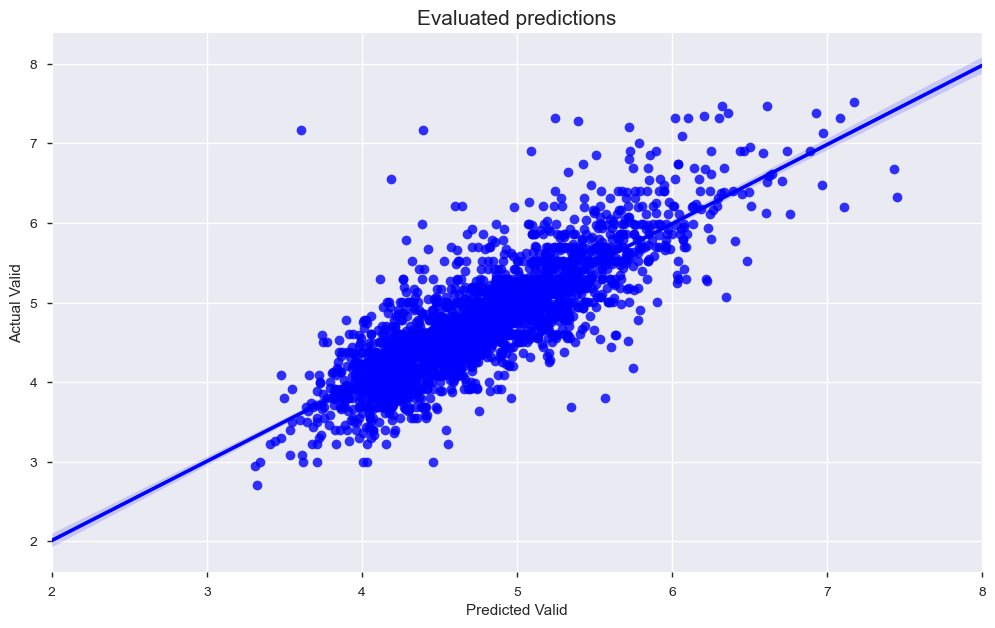

In [225]:
plt.figure(figsize=(12,7))
plt.xlim(2,8)
sns.regplot(y=y_valid, x=y_valid_preds, color='blue')
plt.title('Evaluated predictions', fontsize=15)
plt.xlabel('Predicted Valid')
plt.ylabel('Actual Valid')
plt.show()

In [226]:
xgb_model_cv = XGBRegressor(n_estimators=1000, learning_rate=0.05, early_stopping=5,max_depth=5)
kf = KFold(6, shuffle=True, random_state = 91).get_n_splits()
cv_res = cross_val_score(xgb_model_cv, X_train, y_train, scoring='neg_mean_squared_error', cv=kf)
xgb_model_cv.fit(X_train, y_train)
y_train_preds = xgb_model_cv.predict(X_train)
y_valid_preds = xgb_model_cv.predict(X_valid)
xgb_base_model_cv_results = pd.DataFrame({'algorithm':['XGBRegressor'],
            'CV error': cv_res.mean(), 
            'CV std': cv_res.std(),
            'training error': [mean_squared_error(y_train_preds, y_train)],
            'validation error':[mean_squared_error(y_valid_preds, y_valid)]})

[04:54:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:55:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:57:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:58:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:59:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:01:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:02:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [227]:
print('Train metrics :')
print('MSE :',mean_squared_error(y_train,y_train_preds))
print('RMSE :',rms(y_train,y_train_preds))

print('Validation metrics :')
print('MSE :',mean_squared_error(y_valid,y_valid_preds))
print('RMSE :',rms(y_valid,y_valid_preds))

Train metrics :
MSE : 0.09891085622799055
RMSE : 0.3145009637950102
Validation metrics :
MSE : 0.1635357593064099
RMSE : 0.4043955480793648


In [228]:
#sample_submission = pd.read_csv('AirBnB10K/sample_submission2k.csv')
#y_test_preds = xgb_model_cv.predict(X_test)
#temp = pd.DataFrame({'id':test.id,'log_price':y_test_preds})
#sample_submission.drop('log_price',axis=1,inplace=True)
#sample_submission = sample_submission.merge(temp)
#sample_submission.to_csv('xgboost_base_submission.csv',index=False)